# Lab06

Modelling Plant Gas-Exchange Process (Implementation)

<div class="alert alert-warning">
If figures/tables are not rendered correctly, make sure your notebook is `trusted` by choosing `Trust Notebook` command found in `View` - `Activate Command Palette` menu. Typing in the first letters (i.e. "tr") should give you the command.
</div>

In [1]:
using Cropbox

We will use interactive plotting feature in this notebook. For this, we have to initialize [WebIO.jl](https://github.com/JuliaGizmos/WebIO.jl) manually when using [prebuilt system images](https://github.com/JuliaLang/PackageCompiler.jl) as we do with our JupyterHub environment.

In [2]:
Cropbox.Interact.WebIO.setup(:ijulia)

WebIO._IJuliaInit()

Bisection method used for optimization by default prints out warning messages when it can't find a solution within a given range, for example, when we try running simulation under an extreme condition (*i.e.* some zero values for parameters). Let's make it quiet.

In [3]:
using Logging
Logging.disable_logging(Logging.Warn)

LogLevel(1001)

## Cropbox

Before going into the model, let's briefly talk about the kinds of variable we didn't have a chance to discuss in the previous lab sessions.

### Call

`call` makes a *callable* variable which works like a function. Depending variables declared in the argument list before `;` are mapped to existing variables as usual. Variables declared after `;` indicates these arguments need explicitly supplied when calling the respective `call` variable.

In the example below, `f` is a `call`-kind variable which is dependent on `a` and callable with `x`. Look at how it's called in the declaration of variable `f2`.

In [4]:
@system SCall(Controller) begin
    a       => 1 ~ preserve
    f(a; x) => a + x ~ call
    f2(f)   => f(2) ~ track
end

SCall

In [5]:
simulate(SCall)

Row,time,a,f2
,Quantity…,Float64,Float64
1,0.0 hr,1.0,3.0


In [6]:
s = instance(SCall)

context,,=,<Context>
config,,=,<Config>
a,,=,1.0
f,,=,<call>
f2,,=,3.0


In [7]:
s.f(2)

3.0

In [8]:
@look s.f(2; a = 2)

4.0

### Solve

`solve` derives a symbolic solution of polynomial equation via [SymPy.jl](https://github.com/JuliaPy/SymPy.jl). The equation is solved for the name of variable itself. For example, the variable `x` below is resolved as -1 as $x = -1$ for the equation $x^2 + 2x + 1 = (x + 1)^2$.

In [9]:
@system SSolve(Controller) begin
    a => 1 ~ preserve
    b => 2 ~ preserve
    c => 1 ~ preserve
    x(a, b, c) => a*x^2 + b*x + c ~ solve
end

SSolve

In [10]:
simulate(SSolve)

Row,time,a,b,c,x
,Quantity…,Float64,Float64,Float64,Float64
1,0.0 hr,1.0,2.0,1.0,-1.0


### Bisect

`bisect` also derives a solution of equations. While `solve` can find an analytical solution only when the equation is solvable via symbolic algebra, `bisect` relies on numerical optimizations which are more generally applicable to more types of equations. The downside is that it is much slower and can still fail especially when the given boundary of solution is not correct. The boundary of solution should be given by `lower` and `upper` tags.

In [11]:
@system SBisect(Controller) begin
    x(x) => x - 1 ~ bisect(lower = 0, upper = 2)
end

SBisect

In [12]:
simulate(SBisect)

Row,time,x
,Quantity…,Float64
1,0.0 hr,1.0


## Model

The gas exchange model was originally derived from [MAIZSIM](https://github.com/ARS-CSGCL-DT/MAIZSIM) and reimplemented with Cropbox framework to build [Garlic.jl](https://github.com/cropbox/Garlic.jl). A standalone package is also available as [LeafGasExchange.jl](https://github.com/cropbox/LeafGasExchange.jl) that we used in the lab. In this notebook, we're going to implement (mostly) the same model from scratch to better understand how the model works internally.

### Environment

$$
e_s[T] = 0.611 \cdot \exp\!\left[ \frac{17.502 \cdot T}{240.97 + T} \right]
$$

In [13]:
@system VaporPressure begin
    a => 0.611  ~ preserve(parameter, u"kPa")
    b => 17.502 ~ preserve(parameter)
    c => 240.97 ~ preserve(parameter)

    es(a, b, c; T(u"°C")):                 saturation        => (t = deunitfy(T); a*exp((b*t)/(c+t))) ~ call(u"kPa")
    ea(es;      T(u"°C"), RH(u"percent")): ambient           => es(T) * RH                            ~ call(u"kPa")
    D(es;       T(u"°C"), RH(u"percent")): deficit           => es(T) * (1 - RH)                      ~ call(u"kPa")
    RH(es;      T(u"°C"), VPD(u"kPa")):    relative_humidity => 1 - VPD / es(T)                       ~ call(u"NoUnits")

    Δ(es, b, c; T(u"°C")):            saturation_slope_delta => (e = es(T); t = deunitfy(T); e*(b*c)/(c+t)^2 / u"K") ~ call(u"kPa/K")
    s(Δ;        T(u"°C"), P(u"kPa")): saturation_slope       => Δ(T) / P                                             ~ call(u"K^-1")
end

VaporPressure

In [14]:
@system Weather begin
    vp(context): vapor_pressure ~ ::VaporPressure

    PFD:           photon_flux_density      => 2000 ~ preserve(parameter, u"μmol/m^2/s")
    CO2:           carbon_dioxide           => 400  ~ preserve(parameter, u"μmol/mol")
    RH:            relative_humidity        => 66   ~ preserve(parameter, u"percent")
    T_air:         air_temperature          => 32   ~ preserve(parameter, u"°C")
    Tk_air(T_air): absolute_air_temperature         ~ track(u"K")
    wind:          wind_speed               => 2.0  ~ preserve(parameter, u"m/s")
    P_air:         air_pressure             => 99.4 ~ preserve(parameter, u"kPa")

    VPD(T_air, RH, D=vp.D):      vapor_pressure_deficit                => D(T_air, RH)    ~ track(u"kPa")
    VPD_Δ(T_air, Δ=vp.Δ):        vapor_pressure_saturation_slope_delta => Δ(T_air)        ~ track(u"kPa/K")
    VPD_s(T_air, P_air, s=vp.s): vapor_pressure_saturation_slope       => s(T_air, P_air) ~ track(u"K^-1")
end

Weather

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$\mathcal{D}_w$ | 24.2 | $$\mathrm{mm^2}\ \mathrm{s^{-1}}$$ | Diffusion coefficient for water vapor in air at 20 $\mathrm{^{\circ}C}$ |
$\mathcal{D}_c$ | 14.7 | $\mathrm{mm^2}\ \mathrm{s^{-1}}$ | Diffusion coefficient for $\mathrm{CO_2}$ in air at 20 $\mathrm{^{\circ}C}$ |
$\mathcal{D}_h$ | 21.5 | $\mathrm{mm^2}\ \mathrm{s^{-1}}$ | Diffusion coefficient for heat (thermal diffusivity) in air at 20 $\mathrm{^{\circ}C}$ |
$\mathcal{D}_m$ | 15.1 | $\mathrm{mm^2}\ \mathrm{s^{-1}}$ | Diffusion coefficient for momentum (kinematic viscosity) in air at 20 $\mathrm{^{\circ}C}$ |

In [15]:
@system Diffusion begin
    Dw: diffusion_coeff_for_water_vapor_in_air_at_20 => 24.2 ~ preserve(parameter, u"mm^2/s")
    Dc: diffusion_coeff_for_co2_in_air_at_20         => 14.7 ~ preserve(parameter, u"mm^2/s")
    Dh: diffusion_coeff_for_heat_in_air_at_20        => 21.5 ~ preserve(parameter, u"mm^2/s")
    Dm: diffusion_coeff_for_momentum_in_air_at_20    => 15.1 ~ preserve(parameter, u"mm^2/s")
end

Diffusion

$$
\begin{align}
I_2 &= \frac{(1 - f)}{2} I_a \\
I_a &= \alpha I
\end{align}
$$

| Symbol | Units | Description |
|:-------|:------|:------------|
$I$ | $$\mathrm{\mu mol_{quanta}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$$ | Incident PAR |
$I_a$ | $\mathrm{\mu mol_{quanta}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Absorbed PAR |
$I_2$ | $\mathrm{\mu mol_{quanta}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Effective PAR |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$\alpha$ | 0.85 | - | Leaf absorptance in PAR |
$\delta$ | 0.15 | - | Leaf scattering factor |
$f$ | 0.15 | - | Leaf spectral correction factor |

In [16]:
@system Irradiance begin
    PFD ~ hold
    PPFD(PFD): photosynthetic_photon_flux_density ~ track(u"μmol/m^2/s")

    δ: leaf_scattering          => 0.15 ~ preserve(parameter)
    f: leaf_spectral_correction => 0.15 ~ preserve(parameter)

    Ia(PPFD, δ): absorbed_irradiance  => (PPFD * (1 - δ))   ~ track(u"μmol/m^2/s")
    I2(Ia, f):   effective_irradiance => (Ia * (1 - f) / 2) ~ track(u"μmol/m^2/s")
end

Irradiance

### Photosynthesis

#### Common

$$
\begin{align}
k_{T_A}[T_k, E_a] &= \exp\!\left[ \frac{E_a ( T_k - T_{b_k} )}{R \cdot T_k \cdot T_{b_k}} \right] \\
k_{T_Q}[T] &= Q_{10}^{\frac{T - T_b}{10}} \\
k_{T_P}[T_k, E_a, H, S] &= k_{T_A}[T_k, E_a] \cdot \left( 1 + \exp\!\left[ \frac{S \cdot T_{b_k} - H}{R \cdot T_{b_k}} \right] \right) \left( 1 + \exp\!\left[ \frac{S \cdot T_k - H}{R \cdot T_k} \right] \right)^{-1} \\
\end{align}
$$

| Symbol | Units | Description |
|:-------|:------|:------------|
| $k_{T_A}$ | - | Temperature dependence by Arrhenius equation |
| $k_{T_Q}$ | - | Temperature dependence by $Q_{10}$ function |
| $k_{T_P}$ | - | Temperature dependence by a peaked function |
| $T_a$ | $\mathrm{^{\circ}C}$ | Air temperature in Celsius |
| $T_{a_k}$ | $\mathrm{K}$ | Air temperature in Kelvin |
| $T_l$ | $\mathrm{^{\circ}C}$ | Leaf temperature in Celsius |
| $T_{l_k}$ | $\mathrm{K}$ | Leaf temperature in Kelvin |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$R$ | 8.314 | $$\mathrm{J}\ \mathrm{K^{-1}}\ \mathrm{mol}$$ | Universal gas constant |

In [17]:
@system TemperatureDependence begin
    T: leaf_temperature ~ hold
    Tk(T): absolute_leaf_temperature ~ track(u"K")

    Tb: base_temperature               => 25 ~ preserve(parameter, u"°C")
    Tbk(Tb): absolute_base_temperature       ~ preserve(u"K")

    kT(T, Tk, Tb, Tbk; Ea(u"kJ/mol")): arrhenius_equation => begin
        exp(Ea * (T - Tb) / (u"R" * Tk * Tbk))
    end ~ call

    kTpeak(Tk, Tbk, kT; Ea(u"kJ/mol"), S(u"J/mol/K"), H(u"kJ/mol")): peaked_function => begin
        R = u"R"
        kT(Ea) * (1 + exp((S*Tbk - H) / (R*Tbk))) / (1 + exp((S*Tk - H) / (R*Tk)))
    end ~ call

    Q10 => 2 ~ preserve(parameter)
    kTQ10(T, Tb, Q10): q10_rate => begin
        Q10^((T - Tb) / 10u"K")
    end ~ track
end

TemperatureDependence

$$
k_{N} = \frac{2}{1 + \exp\!\left[ -s \cdot \max \{ N_0, N \} - N_0 \right]} - 1
$$

| Symbol | Units | Description |
|:-------|:------|:------------|
| $k_N$ | - | Nitrogen dependence |
| $N$ | $$\mathrm{g}\ \mathrm{m^{-2}}$$ | Leaf nitrogen content |
| $N_p$ | $\mathrm{\%}$ | Relative leaf nitrogen content assuming SLA = 200 $\mathrm{cm^2}\ \mathrm{g^{-1}}$ |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$N_0$ | 0.343 | $$\mathrm{g}\ \mathrm{m^{-2}}$$ | Baseline leaf nitrogen content |
$s$ | 4.191 | $\mathrm{m^2}\ \mathrm{g^{-1}}$ | Steepness of nitrogen response curve |

In [18]:
@system NitrogenDependence begin
    N: leaf_nitrogen_content => 4.0   ~ preserve(parameter, u"g/m^2")
    s                        => 4.191 ~ preserve(parameter, u"m^2/g")
    N0                       => 0.343 ~ preserve(parameter, u"g/m^2")

    kN(N, s, N0): nitrogen_limited_rate => begin
        2 / (1 + exp(-s * (max(N0, N) - N0))) - 1
    end ~ track

    Np(N, SLA) => N * SLA ~ track(u"percent")
    SLA: specific_leaf_area => 200 ~ preserve(u"cm^2/g")
end

NitrogenDependence

In [19]:
@system CBase(TemperatureDependence, NitrogenDependence) begin
    Ci: intercellular_co2 ~ hold
    I2: effective_irradiance ~ hold
end

CBase

#### C3

| Symbol | Units | Description |
|:-------|:------|:------------|
| $A_c$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Rubisco-limited $\mathrm{CO_2}$ assimilation rate |
| $A_j$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Electron transport-limited $\mathrm{CO_2}$ assimilation rate |
| $A_n$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Net photosynthesis rate |
| $A_p$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Triose phosphate utilization-limited $\mathrm{CO_2}$ assimilation rate |
| $C_a$ | $\mathrm{\mu bar}$ | Atmospheric $\mathrm{CO_2}$ partial pressure |
| $C_i$ | $\mathrm{\mu bar}$ | Intercellular $\mathrm{CO_2}$ partial pressure |
| $C_m$ | $\mathrm{\mu bar}$ | Mesophyll $\mathrm{CO_2}$ partial pressure |
| $\Gamma$ | $\mathrm{\mu bar}$ | $\mathrm{CO_2}$ compensation point |
| $J$ | $$\mathrm{\mu mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$$ | Electron transport rate |
| $J_{\max}$ | $\mathrm{\mu mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of electron transport |
| $K_c$ | $\mathrm{\mu bar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{CO_2}$ |
| $K_m$ | $\mathrm{\mu bar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{CO_2}$ in presence of $\mathrm{O_2}$ |
| $K_o$ | $\mathrm{mbar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{O_2}$ |
| $P_a$ | $\mathrm{kPa}$ | Atmospheric pressure |
| $R_d$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Mitochondrial respiration rate |
| $r_{v_c}$ | $\mathrm{m^2}\ \mathrm{s}\ \mathrm{mol^{-1}_{CO_2}}\ \mathrm{bar}$ | Total leaf resistance to $\mathrm{CO_2}$ |
| $T_p$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of triose phosphate utilization |
| $V_{c\!\max}$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of Rubisco carboxylation |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$E_{ac}$ | 79.43 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $K_c$ |
$E_{ag}$ | 37.83 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $\Gamma$ |
$E_{aj}$ | 23.9976 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $J_{\max}$ |
$E_{ao}$ | 36.38 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $K_o$ |
$E_{ar}$ | 49.39 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $R_d$ |
$E_{aVc}$ | 52.1573 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $V_{c\!\max}$ |
$E_{aTp}$ | 47.10 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $T_p$ |
$\Gamma_{25}$ | 42.75 | $\mathrm{\mu bar}$ | $\mathrm{CO_2}$ compensation point at 25 $\mathrm{^{\circ}C}$ |
$H_j$ | 200 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Curvature parameter for $J_{\max}$ |
$J_{\max_{25}}$ | 169 | $$\mathrm{mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$$ | Maximum rate of electron transport at 25 $\mathrm{^{\circ}C}$ |
$K_{c_{25}}$ | 404.9 | $\mathrm{\mu bar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{CO_2}$ at 25 $\mathrm{^{\circ}C}$ |
$K_{o_{25}}$ | 278.4 | $\mathrm{mbar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{O_2}$ at 25 $\mathrm{^{\circ}C}$ |
$O_m$ | 210 | $\mathrm{mbar}$ | Mesophyll $\mathrm{O_2}$ partial pressure |
$R_{d_{25}}$ | 1.08 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Mitochondrial respiration rate at 25 $\mathrm{^{\circ}C}$ |
$S_j$ | 616.4 | $\mathrm{J}\ \mathrm{mol^{-1}}\ \mathrm{K}$ | Entropy factor for $J_{\max}$ |
$\theta$ | 0.7 | - | Sharpness of transition between light limitation and saturation |
$T_b$ | 25 | $\mathrm{^{\circ}C}$ | Base temperature in Celsius |
$T_{b_k}$ | 298.15 | $\mathrm{K}$ | Base temperature in Kelvin |
$T_{p_{25}}$ | 16.03 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Triose phosphate utilization rate at 25 $\mathrm{^{\circ}C}$ |
$V_{c\!\max_{25}}$ | 108.4 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of Rubisco carboxylation at 25 $\mathrm{^{\circ}C}$ |

In [20]:
@system C3Base(CBase)

C3Base

In [21]:
@system C3c(C3Base) begin
    Kc25: rubisco_constant_for_co2_at_25 => 404.9 ~ preserve(parameter, u"μbar")
    Eac:  activation_energy_for_co2      => 79.43 ~ preserve(u"kJ/mol")
    Kc(Kc25, kT, Eac): rubisco_constant_for_co2 => begin
        Kc25 * kT(Eac)
    end ~ track(u"μbar")

    Ko25: rubisco_constant_for_o2_at_25 => 278.4 ~ preserve(parameter, u"mbar")
    Eao:  activation_energy_for_o2      => 36.38 ~ preserve(parameter, u"kJ/mol")
    Ko(Ko25, kT, Eao): rubisco_constant_for_o2 => begin
        Ko25 * kT(Eao)
    end ~ track(u"mbar")

    Om: mesophyll_o2_partial_pressure => 210 ~ preserve(parameter, u"mbar")
    Km(Kc, Om, Ko): rubisco_constant_for_co2_with_o2 => begin
        Kc * (1 + Om / Ko)
    end ~ track(u"μbar")

    Vcm25: maximum_carboxylation_rate_at_25    => 108.4   ~ preserve(parameter, u"μmol/m^2/s")
    EaVc:  activation_energy_for_carboxylation => 52.1573 ~ preserve(parameter, u"kJ/mol")
    Vcmax(Vcm25, kT, EaVc, kN): maximum_carboxylation_rate => begin
        Vcm25 * kT(EaVc) * kN
    end ~ track(u"μmol/m^2/s")
end

C3c

$$
J = \min\!h \{ I_2, J_{\max}, \theta \}
$$

In [22]:
@system C3j(C3Base) begin
    Jm25: maximum_electron_transport_rate_at_25    => 169.0   ~ preserve(parameter, u"μmol/m^2/s")
    Eaj:  activation_energy_for_electron_transport => 23.9976 ~ preserve(parameter, u"kJ/mol")
    Sj:   electron_transport_temperature_response  => 616.4   ~ preserve(parameter, u"J/mol/K")
    Hj:   electron_transport_curvature             => 200     ~ preserve(parameter, u"kJ/mol")
    Jmax(Jm25, kTpeak, Eaj, Sj, Hj, kN): maximum_electron_transport_rate => begin
        Jm25 * kTpeak(Eaj, Sj, Hj) * kN
    end ~ track(u"μmol/m^2/s")

    θ: light_transition_sharpness => 0.7 ~ preserve(parameter)
    J(I2, Jmax, θ): electron_transport_rate => begin
        θ*J^2 - (I2+Jmax)*J + I2*Jmax ⩵ 0
    end ~ solve(lower = 0, upper = Jmax, u"μmol/m^2/s")
end

C3j

In [23]:
@system C3p(C3Base) begin
    Tp25: triose_phosphate_limitation_at_25 => 16.03 ~ preserve(parameter, u"μmol/m^2/s")
    Eap: activation_energy_for_Tp           => 47.10 ~ preserve(parameter, u"kJ/mol")
    Tp(Tp25, kT, Eap, kN): triose_phosphate_utilization => begin
        Tp25 * kT(Eap) * kN
    end ~ track(u"μmol/m^2/s")
end

C3p

In [24]:
@system C3r(C3Base) begin
    Rd25: dark_respiration_at_25            => 1.08  ~ preserve(parameter, u"μmol/m^2/s")
    Ear:  activation_energy_for_respiration => 49.39 ~ preserve(parameter, u"kJ/mol")
    Rd(Rd25, kT, Ear): dark_respiration => begin
        Rd25 * kT(Ear)
    end ~ track(u"μmol/m^2/s")

    Γ25: co2_compensation_point_at_25                 => 42.75 ~ preserve(parameter, u"μbar")
    Eag: activation_energy_for_co2_compensation_point => 37.83 ~ preserve(parameter, u"kJ/mol")
    Γ(Γ25, kT, Eag): co2_compensation_point => begin
        Γ25 * kT(Eag)
    end ~ track(u"μbar")
end

C3r

$$
A_n = \min \{ A_c, A_j, A_p \}
$$

$$
A_c = V_{c\!\max} \frac{C_i - \Gamma}{C_i + K_c \cdot (1 + \frac{O_m}{K_o})} - R_d
$$

$$
A_j = \frac{J \cdot (C_i - \Gamma)}{4 (C_i + 2 \Gamma)} - R_d
$$

$$
A_p = 3T_p - R_d
$$

In [25]:
@system C3Rate(C3c, C3j, C3p, C3r) begin
    Ac(Vcmax, Ci, Γ, Km, Rd): enzyme_limited_photosynthesis_rate => begin
        Vcmax * (Ci - Γ) / (Ci + Km) - Rd
    end ~ track(u"μmol/m^2/s")

    Aj(J, Ci, Γ, Rd): transport_limited_photosynthesis_rate => begin
        J * (Ci - Γ) / 4(Ci + 2Γ) - Rd
    end ~ track(u"μmol/m^2/s")

    Ap(Tp, Rd): triose_phosphate_limited_photosynthesis_rate => begin
        3Tp - Rd
    end ~ track(u"μmol/m^2/s")

    A_net(Ac, Aj, Ap): net_photosynthesis => begin
        min(Ac, Aj, Ap)
    end ~ track(u"μmol/m^2/s")

    A_gross(A_net, Rd): gross_photosynthesis => begin
        A_net + Rd
    end ~ track(u"μmol/m^2/s")
end

C3Rate

In [26]:
@system C3(C3Rate)

C3

Let's examine how the following individual components of a coupled gas-exchange model are implemented in Cropbox: 1) FvCB model for C3 photosynthesis.

In [27]:
@system C3Controller(C3, Controller) begin
    T:  leaf_temperature     => 25  ~ preserve(parameter, u"°C")
    Ci: intercellular_co2    => 300 ~ preserve(parameter, u"μbar")
    I2: effective_irradiance => 600 ~ preserve(parameter, u"μmol/m^2/s")
end

C3Controller

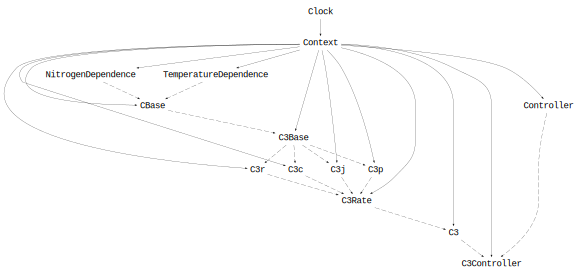

In [28]:
Cropbox.hierarchy(C3Controller)

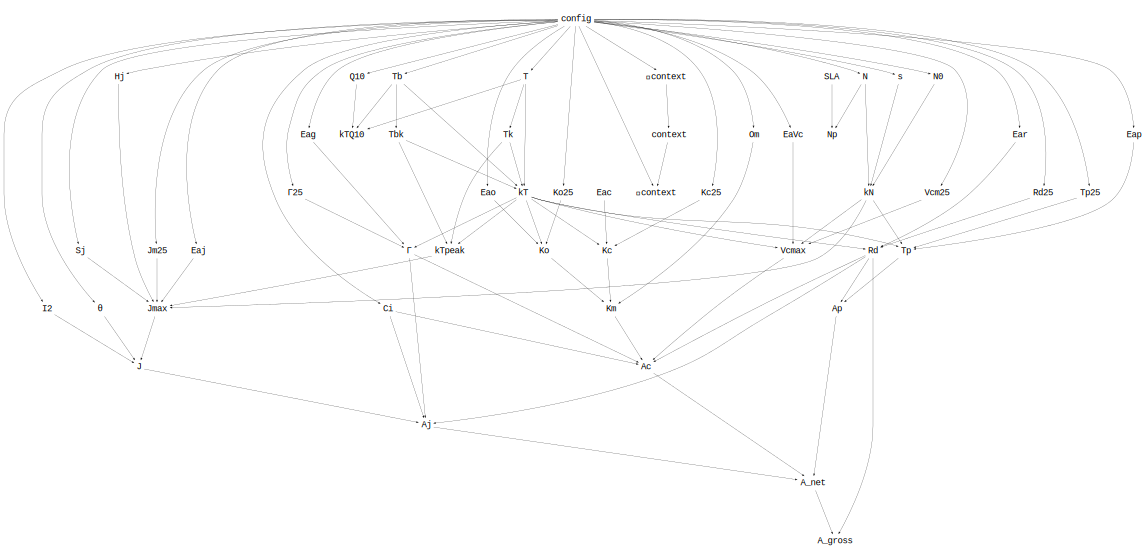

In [29]:
Cropbox.dependency(C3Controller)

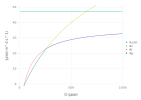

In [30]:
visualize(C3Controller, :Ci, [:A_net, :Ac, :Aj, :Ap];
    xstep = :0 => :Ci => 0:1000,
    ylim = (0,50),
    kind = :line,
)

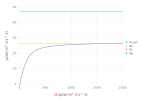

In [31]:
visualize(C3Controller, :I2, [:A_net, :Ac, :Aj, :Ap];
    xstep = :0 => :I2 => 0:2000,
    ylim = (0,50),
    kind = :line,
)

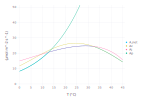

In [32]:
visualize(C3Controller, :T, [:A_net, :Ac, :Aj, :Ap];
    xstep = :0 => :T => 0:45,
    ylim = (0,50),
    kind = :line,
)

#### C4

| Symbol | Units | Description |
|:-------|:------|:------------|
| $A_c$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Rubisco-limited $\mathrm{CO_2}$ assimilation rate |
| $A_j$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Electron transport-limited $\mathrm{CO_2}$ assimilation rate |
| $A_n$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Net photosynthesis rate |
| $C_a$ | $\mathrm{\mu bar}$ | Atmospheric $\mathrm{CO_2}$ partial pressure |
| $C_i$ | $\mathrm{\mu bar}$ | Intercellular $\mathrm{CO_2}$ partial pressure |
| $C_m$ | $\mathrm{\mu bar}$ | Mesophyll $\mathrm{CO_2}$ partial pressure |
| $J$ | $$\mathrm{\mu mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$$ | Electron transport rate |
| $J_{\max}$ | $\mathrm{\mu mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of electron transport |
| $K_c$ | $\mathrm{\mu bar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{CO_2}$ |
| $K_p$ | $\mathrm{\mu bar}$ | Michaelis-Menton constant of PEPC for $\mathrm{CO_2}$ |
| $P_a$ | $\mathrm{kPa}$ | Atmospheric pressure |
| $R_d$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Mitochondrial respiration rate |
| $r_{v_c}$ | $\mathrm{m^2}\ \mathrm{s}\ \mathrm{mol^{-1}_{CO_2}}\ \mathrm{bar}$ | Total leaf resistance to $\mathrm{CO_2}$ |
| $V_p$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | $\mathrm{C_4}$ carboxylation rate |
| $V_{pr}$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | PEP regeneration rate |
| $V_{c\!\max}$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of Rubisco carboxylation |
| $V_{p\!\max}$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of $\mathrm{C_4}$ carboxylation |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$\beta$ | 0.99 | - | Sharpness of transition between $A_c$ and $A_j$ |
$E_{ac}$ | 55.9 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $V_{c\!\max}$ |
$E_{aj}$ | 32.8 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $J_{\max}$ |
$E_{ap}$ | 75.1 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $V_{p\!\max}$ |
$E_{ar}$ | 39.8 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $R_d$ |
$g_{bs}$ | 0.003 | $\mathrm{mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$ | Bundle-sheath conductance to $\mathrm{CO_2}$ |
$H_j$ | 220 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Curvature parameter for $J_{\max}$ |
$J_{\max_{25}}$ | 300 | $$\mathrm{mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$$ | Maximum rate of electron transport at 25 $\mathrm{^{\circ}C}$ |
$K_{c_{25}}$ | 650 | $\mathrm{\mu bar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{CO_2}$ at 25 $\mathrm{^{\circ}C}$ |
$K_{p_{25}}$ | 80 | $\mathrm{\mu bar}$ | Michaelis-Menton constant of PEPC for $\mathrm{CO_2}$ at 25 $\mathrm{^{\circ}C}$ |
$R_{d_{25}}$ | 2 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Mitochondrial respiration rate at 25 $\mathrm{^{\circ}C}$ |
$S_j$ | 702.6 | $\mathrm{J}\ \mathrm{mol^{-1}}\ \mathrm{K}$ | Entropy factor for $J_{\max}$ |
$\theta$ | 0.5 | - | Sharpness of transition between light limitation and saturation |
$T_b$ | 25 | $\mathrm{^{\circ}C}$ | Base temperature in Celsius |
$T_{b_k}$ | 298.15 | $\mathrm{K}$ | Base temperature in Kelvin |
$V_{c\!\max_{25}}$ | 50 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of Rubisco carboxylation at 25 $\mathrm{^{\circ}C}$ |
$V_{p\!\max_{25}}$ | 70 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of PEP carboxylation at 25 $\mathrm{^{\circ}C}$ |
$V_{pr_{25}}$ | 80 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | PEP regeneration rate at 25 $\mathrm{^{\circ}C}$ |
$x$ | 0.4 | - | Partitioning factor of electron transport rate |

In [33]:
@system C4Base(CBase) begin
    Cm(Ci): mesophyll_co2                      ~ track(u"μbar")
    gbs:    bundle_sheath_conductance => 0.003 ~ preserve(parameter, u"mol/m^2/s/bar")
end

C4Base

$$
V_p = \min \Bigg\{ \frac{C_m V_{p\!\max}}{C_m + K_p}, V_{pr} \Bigg\}
$$

In [34]:
@system C4c(C4Base) begin
    Kp25: pep_carboxylase_constant_for_co2_at_25 => 80 ~ preserve(parameter, u"μbar")
    Kp(Kp25, kTQ10): pep_carboxylase_constant_for_co2 => begin
        Kp25 * kTQ10
    end ~ track(u"μbar")

    Vpm25: maximum_pep_carboxylation_rate_for_co2_at_25 => 70   ~ preserve(parameter, u"μmol/m^2/s")
    EaVp:  activation_energy_for_pep_carboxylation      => 75.1 ~ preserve(parameter, u"kJ/mol")
    Vpmax(Vpm25, kT, EaVp, kN): maximum_pep_carboxylation_rate => begin
        Vpm25 * kT(EaVp) * kN
    end ~ track(u"μmol/m^2/s")

    Vpr25: regeneration_limited_pep_carboxylation_rate_for_co2_at_25 => 80 ~ preserve(parameter, u"μmol/m^2/s")
    Vpr(Vpr25, kTQ10): regeneration_limited_pep_carboxylation_rate => begin
        Vpr25 * kTQ10
    end ~ track(u"μmol/m^2/s")
    Vp(Vpmax, Vpr, Cm, Kp): pep_carboxylation_rate => begin
        (Cm * Vpmax) / (Cm + Kp)
    end ~ track(u"μmol/m^2/s", max = Vpr)

    Vcm25: maximum_carboxylation_rate_at_25    => 50   ~ preserve(parameter, u"μmol/m^2/s")
    EaVc:  activation_energy_for_carboxylation => 55.9 ~ preserve(parameter, u"kJ/mol")
    Vcmax(Vcm25, kT, EaVc, kN): maximum_carboxylation_rate => begin
        Vcm25 * kT(EaVc) * kN
    end ~ track(u"μmol/m^2/s")
end

C4c

$$
J = \min\!h \{ I_2, J_{\max}, \theta \}
$$

In [35]:
@system C4j(C4Base) begin
    Jm25: maximum_electron_transport_rate_at_25    => 300   ~ preserve(parameter, u"μmol/m^2/s")
    Eaj:  activation_energy_for_electron_transport => 32.8  ~ preserve(parameter, u"kJ/mol")
    Sj:   electron_transport_temperature_response  => 702.6 ~ preserve(parameter, u"J/mol/K")
    Hj:   electron_transport_curvature             => 220   ~ preserve(parameter, u"kJ/mol")
    Jmax(Jm25, kTpeak, Eaj, Sj, Hj, kN): maximum_electron_transport_rate => begin
        Jm25 * kTpeak(Eaj, Sj, Hj) * kN
    end ~ track(u"μmol/m^2/s")

    θ: light_transition_sharpness => 0.5 ~ preserve(parameter)
    J(I2, Jmax, θ): electron_transport_rate => begin
        θ*J^2 - (I2+Jmax)*J + I2*Jmax ⩵ 0
    end ~ solve(lower = 0, upper = Jmax, u"μmol/m^2/s")
end

C4j

In [36]:
@system C4r(C4Base) begin
    Kc25: rubisco_constant_for_co2_at_25 => 650  ~ preserve(parameter, u"μbar")
    Eac:  activation_energy_for_co2      => 59.4 ~ preserve(parameter, u"kJ/mol")
    Kc(kT, Kc25, Eac): rubisco_constant_for_co2 => begin
        Kc25 * kT(Eac)
    end ~ track(u"μbar")

    Ko25: rubisco_constant_for_o2_at_25 => 450 ~ preserve(parameter, u"mbar")
    Eao:  activation_energy_for_o2      => 36  ~ preserve(parameter, u"kJ/mol")
    Ko(Ko25, kT, Eao): rubisco_constant_for_o2 => begin
        Ko25 * kT(Eao)
    end ~ track(u"mbar")

    Om: mesophyll_o2_partial_pressure => 210 ~ preserve(parameter, u"mbar")
    Km(Kc, Om, Ko): rubisco_constant_for_co2_with_o2 => begin
        Kc * (1 + Om / Ko)
    end ~ track(u"μbar")

    Rd25: dark_respiration_at_25            => 2    ~ preserve(parameter, u"μmol/m^2/s")
    Ear:  activation_energy_for_respiration => 39.8 ~ preserve(parameter, u"kJ/mol")
    Rd(Rd25, kT, Ear): dark_respiration => begin
        Rd25 * kT(Ear)
    end ~ track(u"μmol/m^2/s")
    Rm(Rd) => 0.5Rd ~ track(u"μmol/m^2/s")
end

C4r

$$
A_n = \min\!h \{ A_c, A_j, \beta \}
$$

$$
\begin{align}
A_c &= \min \{ A_{c_1}, A_{c_2} \} \\
A_{c_1} &= V_p + g_{bs} C_m - R_m \\
A_{c_2} &= V_{c\!\max} - R_d \\
\end{align}
$$

$$
\begin{align}
A_j &= \min \{ A_{j_1}, A_{j_2} \} \\
A_{j_1} &= \frac{xJ}{2} - R_m + g_{bs} C_m \\
A_{j_2} &= \frac{(1-x)J}{3} - R_d \\
\end{align}
$$

In [37]:
@system C4Rate(C4c, C4j, C4r) begin
    Ac1(Vp, gbs, Cm, Rm) => (Vp + gbs*Cm - Rm) ~ track(u"μmol/m^2/s")
    Ac2(Vcmax, Rd)       => (Vcmax - Rd)       ~ track(u"μmol/m^2/s")
    Ac(Ac1, Ac2): enzyme_limited_photosynthesis_rate => begin
        min(Ac1, Ac2)
    end ~ track(u"μmol/m^2/s")

    x: electron_transport_partitioning_factor => 0.4 ~ preserve(parameter)
    Aj1(x, J, Rm, gbs, Cm) => (x * J/2 + gbs*Cm - Rm) ~ track(u"μmol/m^2/s")
    Aj2(x, J, Rd)          => (1-x) * J/3 - Rd        ~ track(u"μmol/m^2/s")
    Aj(Aj1, Aj2): transport_limited_photosynthesis_rate => begin
        min(Aj1, Aj2)
    end ~ track(u"μmol/m^2/s")

    β: photosynthesis_transition_factor => 0.99 ~ preserve(parameter)
    A_net(Ac, Aj, β): net_photosynthesis => begin
        x = A_net
        a = β
        b = -(Ac+Aj)
        c = Ac*Aj
        a*x^2 + b*x + c ⩵ 0
    end ~ solve(pick = :minimum, u"μmol/m^2/s")

    A_gross(A_net, Rd): gross_photosynthesis => begin
        A_gross = A_net + Rd
    end ~ track(u"μmol/m^2/s")
end

C4Rate

In [38]:
@system C4(C4Rate)

C4

Let's examine how the biochemical model of C4 photosynthesis by von Caemmerer is implemented in Cropbox.

In [39]:
@system C4Controller(C4, Controller) begin
    T: leaf_temperature      => 25  ~ preserve(parameter, u"°C")
    Ci: intercellular_co2    => 300 ~ preserve(parameter, u"μbar")
    I2: effective_irradiance => 600 ~ preserve(parameter, u"μmol/m^2/s")
end

C4Controller

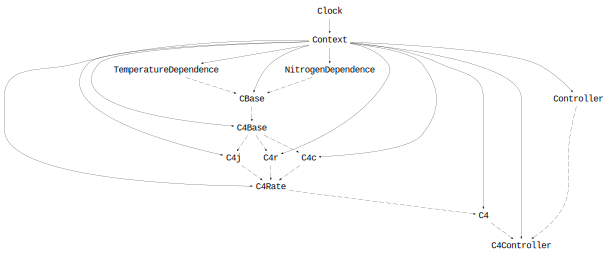

In [40]:
Cropbox.hierarchy(C4Controller)

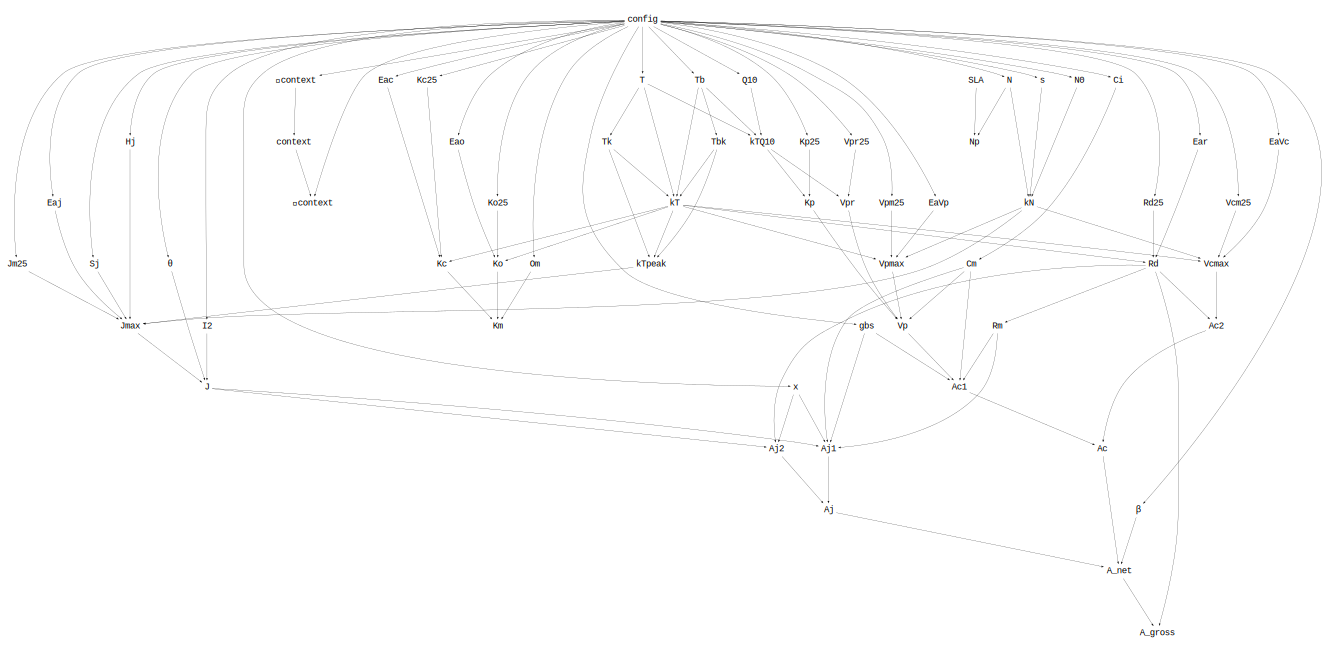

In [41]:
Cropbox.dependency(C4Controller)

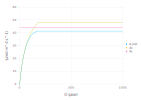

In [42]:
visualize(C4Controller, :Ci, [:A_net, :Ac, :Aj];
    xstep = :0 => :Ci => 0:1000,
    ylim = (0,60),
    kind = :line,
)

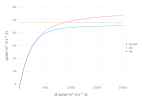

In [43]:
visualize(C4Controller, :I2, [:A_net, :Ac, :Aj];
    xstep = :0 => :I2 => 0:2000,
    ylim = (0,60),
    kind = :line,
)

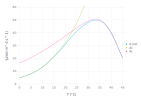

In [44]:
visualize(C4Controller, :T, [:A_net, :Ac, :Aj];
    xstep = :0 => :T => 0:45,
    ylim = (0,60),
    kind = :line,
)

### Interface

#### Boundary Layer

$$
\begin{align}
g_H &= \frac{\mathcal{D}_h \cdot \mathtt{Nu}}{d} \\
\mathtt{Nu} &= 0.60 \sqrt{\mathtt{Re}} \\
\mathtt{Re} &= \frac{u \cdot d}{\mathcal{D}_m} \\
d &= 0.72 w \label{eq:g_H:d} \\
g_h &= g_H \cdot \frac{P_a}{R \cdot T_{a_k}} \\
g_b &= \frac{g_h}{P_a} \cdot {\left( \frac{\mathcal{D}_w}{\mathcal{D}_h} \right)}^{\!\frac{2}{3}} \\
\end{align}
$$

| Symbol | Units | Description |
|:-------|:------|:------------|
$d$ | $\mathrm{m}$ | Leaf characteristic dimension |
$g_b$ | $$\mathrm{mol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$$ | Boundary layer conductance to water vapor |
$g_h$ | $\mathrm{mmol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Leaf convective heat conductance in molar flux |
$g_H$ | $\mathrm{m}\ \mathrm{s^{-1}}$ | Leaf convective heat conductance |
$r_{b_c}$ | $\mathrm{m^2}\ \mathrm{s}\ \mathrm{mol^{-1}_{CO_2}}\ \mathrm{bar}$ | Boundary layer resistance to $\mathrm{CO_2}$ |
$u$ | $\mathrm{m}\ \mathrm{s^{-1}}$ | Wind speed |

In [45]:
@system BoundaryLayer(Weather, Diffusion) begin
    w: leaf_width => 10 ~ preserve(u"cm", parameter)

    sr:      stomatal_ratio            => 1.0                       ~ preserve(parameter)
    scr(sr): sides_conductance_ratio   => ((sr + 1)^2 / (sr^2 + 1)) ~ preserve
    ocr:     outdoor_conductance_ratio => 1.4                       ~ preserve

    u(u = wind): wind_velocity                         ~ track(min = 0.1, u"m/s")
    d(w):        characteristic_dimension   => 0.72w   ~ track(u"m")
    v(Dm):       kinematic_viscosity_of_air            ~ preserve(u"m^2/s")
    κ(Dh):       thermal_diffusivity_of_air            ~ preserve(u"m^2/s")
    Re(u, d, v): reynolds_number            => u*d/v   ~ track
    Nu(Re):      nusselt_number             => 0.60*√Re ~ track
    gh(κ, Nu, d, scr, ocr, P_air, Tk_air): boundary_layer_heat_conductance => begin
        g = κ * Nu / d
        g *= scr * ocr
        g * P_air / (u"R" * Tk_air)
    end ~ track(u"mmol/m^2/s")

    rhw(Dw, Dh):        ratio_from_heat_to_water_vapor => (Dw / Dh)^(2/3)  ~ preserve
    gb(rhw, gh, P_air): boundary_layer_conductance     => rhw * gh / P_air ~ track(u"mol/m^2/s/bar")
end

BoundaryLayer

#### Stomata

| Symbol | Units | Description |
|:-------|:------|:------------|
$D_s$ | $\mathrm{kPa}$ | Vapor pressure deficit at the leaf surface |
$f_{\Psi_v}$ | - | Water stress factor |
$g_s$ | $$\mathrm{mol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$$ | Stomatal conductance to water vapor |
$g_{s_\textrm{BB}}$ | $\mathrm{mol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$ | Stomatal conductance to water vapor from Ball--Berry model |
$g_{s_\textrm{MED}}$ | $\mathrm{mol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$ | Stomatal conductance to water vapor from Medlyn model |
$\mathrm{RH}$ | $\mathrm{\%}$ | Relative humidity of the air (0-100) |
$h_a$ | - | Relative humidity of the air (0-1) |
$h_s$ | - | Relative humidity at the leaf surface (0-1) |
$w_a$ | $\mathrm{kPa}$ | Water vapor pressure in the air |
$w_i$ | $\mathrm{kPa}$ | Water vapor pressure in the intercellular space |
$w_s$ | $\mathrm{kPa}$ | Water vapor pressure at the leaf surface |
$\Psi_v$ | $\mathrm{MPa}$ | Bulk leaf water potential |
$r_{s_c}$ | $\mathrm{m^2}\ \mathrm{s}\ \mathrm{mol^{-1}_{CO_2}}\ \mathrm{bar}$ | Stomatal resistance to $\mathrm{CO_2}$ |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$\Psi_f$ | -2.0 | $\mathrm{MPa}$ | Reference water potential |
$s_f$ | 2.3 | $\mathrm{MPa}$ | Sensitivity of water response |

$$
C_s = C_a - A_n r_{b_c}
$$

In [46]:
@system StomataBase(Weather, Diffusion) begin
    gs:    stomatal_conductance       ~ hold
    gb:    boundary_layer_conductance ~ hold
    A_net: net_photosynthesis         ~ hold
    T:     leaf_temperature           ~ hold

    drb(Dw, Dc):        diffusivity_ratio_boundary_layer => (Dw / Dc)^(2/3)       ~ preserve
    dra(Dw, Dc):        diffusivity_ratio_air            => (Dw / Dc)             ~ preserve

    Ca(CO2, P_air):     co2_air                          => (CO2 * P_air)         ~ track(u"μbar")
    Cs(Ca, A_net, gbc): co2_at_leaf_surface              => (Ca - A_net / gbc)    ~ track(u"μbar")

    gv(gs, gb):         total_conductance_h2o            => (gs * gb / (gs + gb)) ~ track(u"mol/m^2/s/bar")

    rbc(gb, drb):       boundary_layer_resistance_co2    => (drb / gb)            ~ track(u"m^2*s/mol*bar")
    rsc(gs, dra):       stomatal_resistance_co2          => (dra / gs)            ~ track(u"m^2*s/mol*bar")
    rvc(rbc, rsc):      total_resistance_co2             => (rbc + rsc)           ~ track(u"m^2*s/mol*bar")

    gbc(rbc):           boundary_layer_conductance_co2   => (1 / rbc)             ~ track(u"mol/m^2/s/bar")
    gsc(rsc):           stomatal_conductance_co2         => (1 / rsc)             ~ track(u"mol/m^2/s/bar")
    gvc(rvc):           total_conductance_co2            => (1 / rvc)             ~ track(u"mol/m^2/s/bar")
end

StomataBase

$$
f_{\Psi_v} = \frac{1 + \exp\!\left[ s_f \Psi_f \right]}{1 + \exp\!\left[ s_f (\Psi_f - \Psi_v) \right]}
$$

In [47]:
@system StomataTuzet begin
    Ψv: leaf_water_potential           => 0    ~ preserve(parameter, u"MPa")
    Ψf: reference_leaf_water_potential => -1.2 ~ preserve(parameter, u"MPa")
    sf: stomata_sensitivity_param      => 2.3  ~ preserve(parameter, u"MPa^-1")
    fΨv(Ψv, Ψf, sf): stomata_sensitivty => begin
        (1 + exp(sf*Ψf)) / (1 + exp(sf*(Ψf-Ψv)))
    end ~ track
end

StomataTuzet

##### Ball-Berry Model

$$
g_{s_\textrm{BB}} = g_{0_\textrm{BB}} + g_{1_\textrm{BB}} \frac{h_s A_n}{C_s} f_{\Psi_v}
$$

$$
(h_s - h_a) g_b = (1 - h_s) g_{s_\textrm{BB}}
$$

In [48]:
@system StomataBallBerry(StomataBase, StomataTuzet) begin
    g0 ~ preserve(parameter, u"mol/m^2/s/bar")
    g1 ~ preserve(parameter)

    hs(g0, g1, gb, A_net, Cs, fΨv, RH): relative_humidity_at_leaf_surface => begin
        gs = g0 + g1*(A_net*hs/Cs) * fΨv
        (hs - RH)*gb ⩵ (1 - hs)*gs
    end ~ solve(lower = 0, upper = 1)

    Ds(D = vp.D, T, hs): vapor_pressure_deficit_at_leaf_surface => begin
        D(T, hs)
    end ~ track(u"kPa")

    gs(g0, g1, A_net, hs, Cs, fΨv): stomatal_conductance => begin
        g0 + g1*(A_net*hs/Cs) * fΨv
    end ~ track(min = g0, u"mol/m^2/s/bar")
end

StomataBallBerry

Let's examine how the following individual components of a coupled gas-exchange model are implemented in Cropbox: 2) Ball-Berry model for stomatal conductance.

In [49]:
@system StomataBallBerryController(StomataBallBerry, BoundaryLayer, Controller) begin
    A_net: net_photosynthesis => 40 ~ preserve(parameter, u"μmol/m^2/s")
    T:     leaf_temperature   => 25 ~ preserve(parameter, u"°C")

    g0 => 0.1 ~ preserve(parameter, u"mol/m^2/s/bar")
    g1 => 4.0 ~ preserve(parameter)
end

StomataBallBerryController

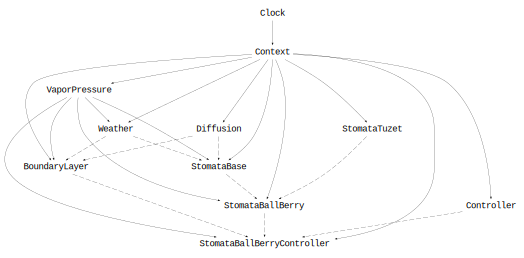

In [50]:
Cropbox.hierarchy(StomataBallBerryController)

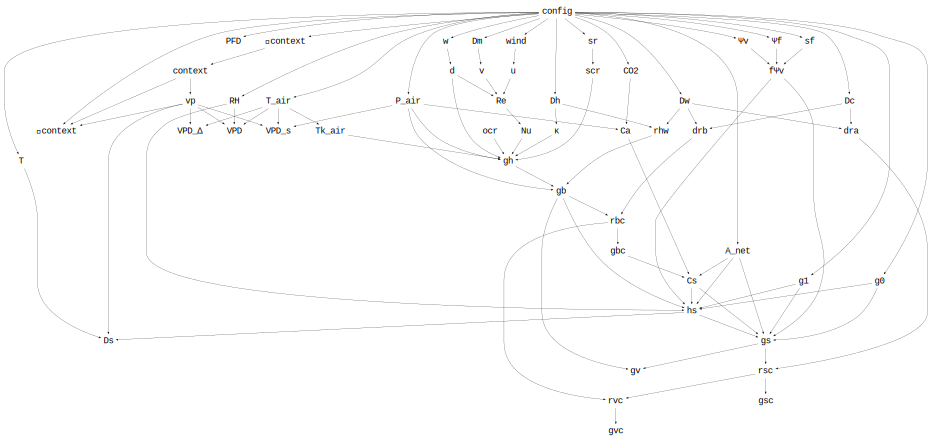

In [51]:
Cropbox.dependency(StomataBallBerryController)

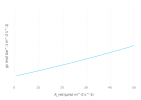

In [52]:
visualize(StomataBallBerryController, :A_net, :gs;
    xstep = :0 => :A_net => 0:50,
    kind=:line
)

Cropbox provides `manipulate()` function for creating interactive plots. It looks like `visualize()` but requires additional range of parameter values in `parameters` argument as similar to `calibrate()` function. These parameter ranges will be automatically transformed into a set of interactive widgets like sliders that uses can *manipulate*. This feature is implemented based on [Interact.jl](https://github.com/JuliaGizmos/Interact.jl) and [WebIO.jl](https://github.com/JuliaGizmos/WebIO.jl).

In [53]:
manipulate(StomataBallBerryController, :A_net, :gs;
    parameters = :StomataBallBerry => (;
        g0 = 0:0.01:1,
        g1 = 0:0.1:10,
    ),
    xstep = :0 => :A_net => 0:50,
    ylim = (0,2),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["StomataBallBerry"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["g0 (mol bar^-1 m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe2e694aca0, Task (runnable) @0x00007fe2e694aca0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n       

##### Medlyn Model

$$
g_{s_\textrm{MED}} = g_{0_\textrm{MED}} + \bigg( 1 + \frac{g_{1_\textrm{MED}}}{\sqrt{D_s}} \bigg) \frac{A_n}{C_s} f_{\Psi_v}
$$

$$
(w_s - w_a) g_b = (w_i - w_s) g_{s_\textrm{MED}}
$$

In [54]:
@system StomataMedlyn(StomataBase, StomataTuzet) begin
    g0 ~ preserve(parameter, u"mol/m^2/s/bar")
    g1 ~ preserve(parameter, u"√kPa")

    wa(ea = vp.ea, T_air, RH): vapor_pressure_at_air                 => ea(T_air, RH) ~ track(u"kPa")
    wi(es = vp.es, T):         vapor_pressure_at_intercellular_space => es(T)         ~ track(u"kPa")
    ws(Ds, wi): vapor_pressure_at_leaf_surface                       => (wi - Ds)     ~ track(u"kPa")

    Ds¹ᐟ²(g0, g1, gb, A_net, Cs, fΨv, wi, wa) => begin
        gs = g0 + (1 + g1 / Ds¹ᐟ²) * (A_net / Cs) * fΨv
        ws = wi - Ds¹ᐟ²^2
        (ws - wa)*gb ⩵ (wi - ws)*gs
    end ~ solve(lower = 0, upper = √wi', u"√kPa")
    Ds(Ds¹ᐟ²): vapor_pressure_deficit_at_leaf_surface => Ds¹ᐟ²^2 ~ track(min = 1u"Pa", u"kPa")

    hs(RH = vp.RH, T, Ds): relative_humidity_at_leaf_surface => RH(T, Ds) ~ track

    gs(g0, g1, A_net, Ds, Cs, fΨv): stomatal_conductance => begin
        g0 + (1 + g1/√Ds)*(A_net/Cs) * fΨv
    end ~ track(min = g0, u"mol/m^2/s/bar")
end

StomataMedlyn

#### Intercellular Space

$$
\begin{align}
C_m \approx C_i &= C_a - \frac{A_n}{g_{v_c}} \\
g_{v_c} &= \frac{1}{r_{v_c}} \\
r_{v_c} &= r_{s_c} + r_{b_c} \\
r_{s_c} &= \frac{1}{g_s} \cdot {\left( \frac{\mathcal{D}_w}{\mathcal{D}_c} \right)}^{\!1}  \\
r_{b_c} &= \frac{1}{g_b} \cdot {\left( \frac{\mathcal{D}_w}{\mathcal{D}_c} \right)}^{\!\frac{2}{3}}
\end{align}
$$

In [55]:
@system IntercellularSpace(Weather) begin
    A_net ~ hold
    gvc   ~ hold

    Ca(CO2, P_air): co2_air                       => (CO2 * P_air) ~ track(u"μbar")
    Cimax(Ca):      intercellular_co2_upper_limit => 2Ca           ~ track(u"μbar")
    Cimin:          intercellular_co2_lower_limit => 0             ~ preserve(u"μbar")
    Ci(Ca, Ci, A_net, gvc): intercellular_co2 => begin
        Ca - Ci ⩵ A_net / gvc
    end ~ bisect(min = Cimin, upper = Cimax, u"μbar")
end

IntercellularSpace

Let's examine the coupling process of the sub-models for photosynthesis and transpiration through stomatal conductance.

### Energy Balance

$$
T_l = T_a + \Delta T
$$

$$
R_n - H - \lambda E = 0
$$

$$
\begin{align}
R_n &= R_{sw} + R_{lw} \\
R_{sw} &= \alpha_s k I \\
R_{lw} &= 2 \epsilon \sigma (T_{a_k}^4 - T_{l_k}^4)
\end{align}
$$

$$
H = C_p g_h \Delta T
$$

$$
\begin{align}
E &= g_v \Delta w \\
g_v &= \frac{1}{\cfrac{1}{g_s} + \cfrac{1}{g_b}} \\
D &= e_s[T_l] - e_a
\end{align}
$$

| Symbol | Units | Description |
|:-------|:------|:------------|
$\Delta w$ | $\mathrm{kPa}$ | Vapor pressure gradient between leaf surface and the air |
$e_a$ | $\mathrm{kPa}$ | Vapor pressure in the ambient air |
$e_s$ | $\mathrm{kPa}$ | Saturated vapor pressure |
$E$ | $\mathrm{mmol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Transpiration rate |
$g_v$ | $$\mathrm{mol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$$ | Total leaf conductance to water vapor |
$H$ | $\mathrm{W}\ \mathrm{m^{-2}}$ | Sensible heat flux |
$\lambda E$ | $\mathrm{W}\ \mathrm{m^{-2}}$ | Latent heat flux |
$R_n$ | $\mathrm{W}\ \mathrm{m^{-2}}$ | Net radiation absorbed |
$\Delta T$ | $\mathrm{K}$ | Temperature difference between $T_l$ and $T_a$ |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$\alpha_s$ | 0.79 | - | Radiation absorption coefficient of the leaf |
$C_p$ | 29.3 | $\mathrm{J}\ \mathrm{mol^{-1}}\ \mathrm{K^{-1}}$ | Specific heat of air |
$\epsilon$ | 0.97 | - | Leaf thermal emissivity |
$k$ | 0.22 | $\mathrm{J}\ \mathrm{\mu mol^{-1}}$ | Radiation conversion factor |
$\lambda$ | 44 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Latent heat of vaporization at 25 $\mathrm{^{\circ}C}$ |
$\sigma$ | $$5.670 \times 10^{-8}$$ | $$\mathrm{W}\ \mathrm{m^{-2}}\ \mathrm{K^{-4}}$$ | Stefan-Boltzmann constant |

In [56]:
@system EnergyBalance(Weather) begin
    gv ~ hold
    gh ~ hold
    PPFD ~ hold

    ϵ:  leaf_thermal_emissivity           => 0.97 ~ preserve(parameter)
    σ:  stefan_boltzmann_constant         => u"σ" ~ preserve(u"W/m^2/K^4")
    λ:  latent_heat_of_vaporization_at_25 => 44   ~ preserve(parameter, u"kJ/mol")
    Cp: specific_heat_of_air              => 29.3 ~ preserve(parameter, u"J/mol/K")

    k:              radiation_conversion_factor         => (1 / 4.55)   ~ preserve(u"J/μmol")
    α_s:            absorption_coefficient              => 0.79         ~ preserve(parameter)
    PAR(PPFD, k):   photosynthetically_active_radiation => (PPFD * k)   ~ track(u"W/m^2")
    R_sw(PAR, α_s): shortwave_radiation_absorbed         => (α_s * PAR) ~ track(u"W/m^2")

    R_wall(ϵ, σ, Tk_air):      thermal_radiation_absorbed_from_wall => 2ϵ*σ*Tk_air^4    ~ track(u"W/m^2")
    R_leaf(ϵ, σ, Tk):          thermal_radiation_emitted_by_leaf    => 2ϵ*σ*Tk^4        ~ track(u"W/m^2")
    R_thermal(R_wall, R_leaf): thermal_radiation_absorbed           => R_wall - R_leaf  ~ track(u"W/m^2")
    R_net(R_sw, R_thermal):    net_radiation_absorbed               => R_sw + R_thermal ~ track(u"W/m^2")

    Δw(T, T_air, RH, ea = vp.ambient, es = vp.saturation): leaf_vapor_pressure_gradient => begin
        es(T) - ea(T_air, RH)
    end ~ track(u"kPa")
    E(gv, Δw): transpiration => gv*Δw ~ track(u"mmol/m^2/s")

    H(Cp, gh, ΔT): sensible_heat_flux => Cp*gh*ΔT ~ track(u"W/m^2")
    λE(λ, E):      latent_heat_flux   => λ*E      ~ track(u"W/m^2")

    ΔT(R_net, H, λE): temperature_adjustment => begin
        R_net ⩵ H + λE
    end ~ bisect(lower = -10, upper = 10, u"K", evalunit = u"W/m^2")

    T(T_air, ΔT): leaf_temperature          => (T_air + ΔT) ~ track(u"°C")
    Tk(T):        absolute_leaf_temperature                 ~ track(u"K")
end

EnergyBalance

Let's examine how the following individual components of a coupled gas-exchange model are implemented in Cropbox: 3) energy balance equation to calculate transpiration and leaf temperature.

Variable `ΔT` implemented with `bisect` will try a range of values between `lower` and `upper` boundary to find the best solution satisfying the equation (`R_net ⩵ H + λE`) in the declaration body. It corresponds to the outer loop illustrated in the schematic diagram of a coupled gas-exchange model flow.

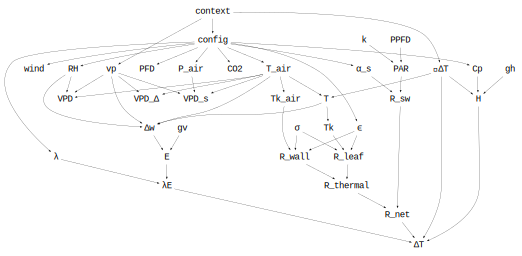

In [57]:
Cropbox.dependency(EnergyBalance)

In [58]:
display("text/plain", Cropbox.dependency(EnergyBalance))

[k → σ → PPFD → PAR → gh → gv → context → ∘ΔT → vp → config → α_s → R_sw → Cp → H → λ → ϵ → P_air → wind → T_air → T → Tk → R_leaf → VPD_s → VPD_Δ → Tk_air → R_wall → R_thermal → R_net → RH → Δw → E → λE → ΔT → VPD → CO2 → PFD]

### Coupling

In [59]:
@system GasExchange(Weather, BoundaryLayer, StomataBase, IntercellularSpace, Irradiance, EnergyBalance)

GasExchange

In [60]:
@system C3BB(GasExchange, StomataBallBerry, C3, Controller) begin
    g0 => 0.096 ~ preserve(parameter, u"mol/m^2/s/bar")
    g1 => 6.824 ~ preserve(parameter)
end

C3BB

In [61]:
@system C4BB(GasExchange, StomataBallBerry, C4, Controller) begin
    g0 => 0.036 ~ preserve(parameter, u"mol/m^2/s/bar")
    g1 => 2.792 ~ preserve(parameter)
end

C4BB

In [62]:
@system C4MED(GasExchange, StomataMedlyn, C4, Controller) begin
    g0 => 0.031 ~ preserve(parameter, u"mol/m^2/s/bar")
    g1 => 1.281 ~ preserve(parameter, u"√kPa")
end

C4MED

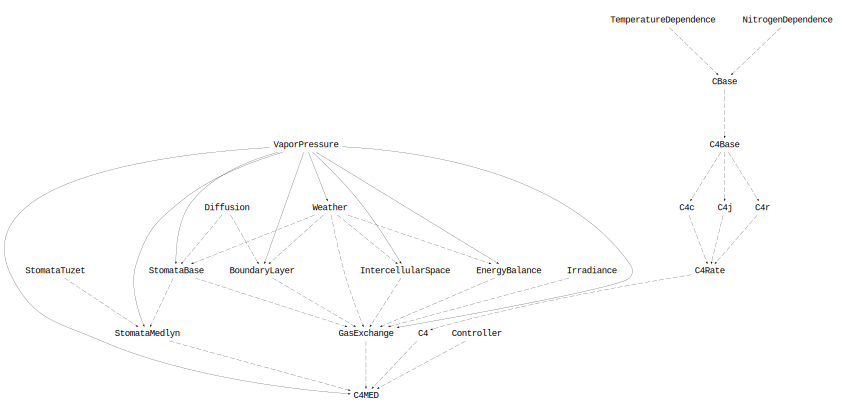

In [63]:
Cropbox.hierarchy(C4MED; skipcontext=true)

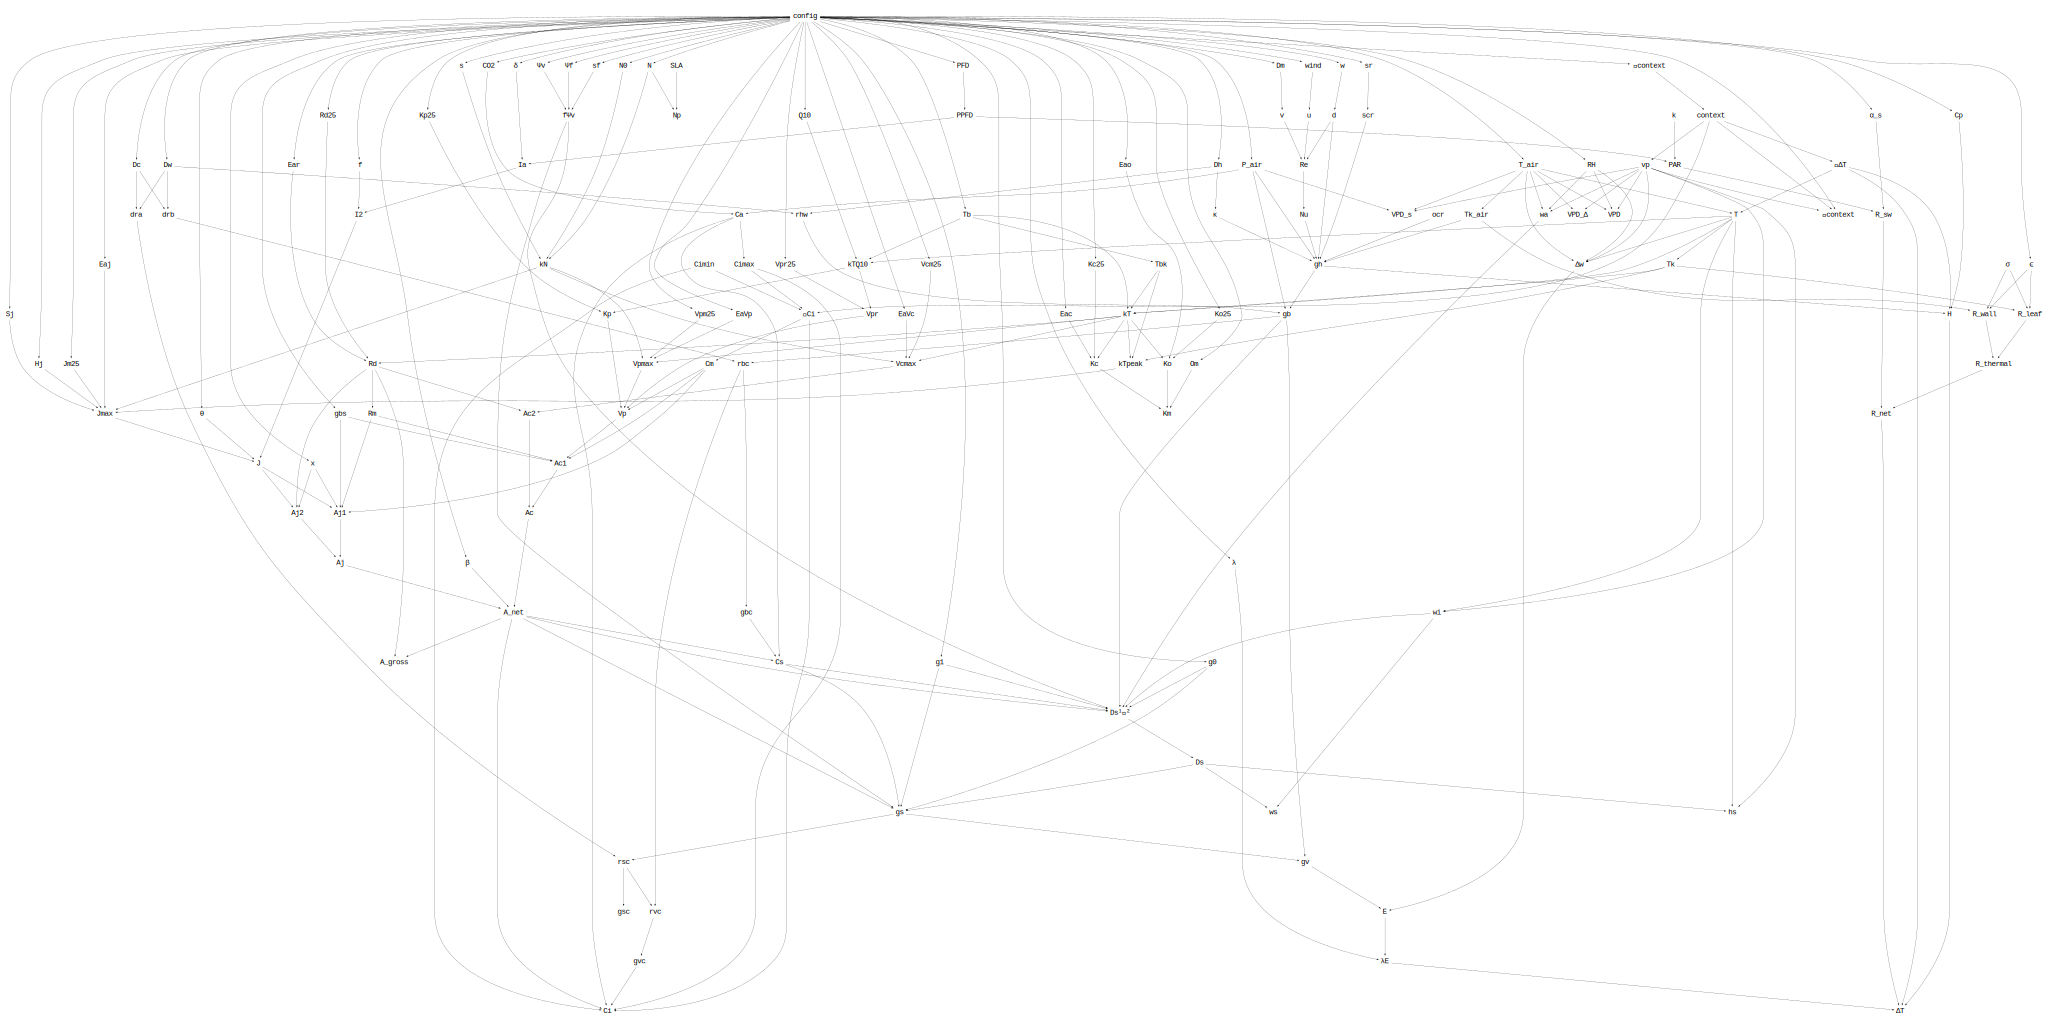

In [64]:
Cropbox.dependency(C4MED)

## Results

Based on the coupled models of C3 and C4 leaves, generate $A/C_i$ and light response ($A/Q$) curves for C3 and C4 leaves, and identify limiting processes (Ac, Aj, or Ap). Assume that all other conditions are optimal for photosynthesis except the variable of interest (*i.e.*, CO2 and PFD).

In [65]:
parameters(Weather)

PFD,=,2000 μmol m^-2 s^-1
CO2,=,400 μmol mol^-1
RH,=,66 %
T_air,=,32 °C
wind,=,2.0 m s^-1
P_air,=,99.4 kPa


In [66]:
co2_xstep = :Weather => :CO2   => 10:10:1500;
pfd_xstep = :Weather => :PFD   => 0:20:2000;
ta_xstep  = :Weather => :T_air => 0:1:45;
rh_xstep  = :Weather => :RH    => 0:1:100;

In [67]:
co2_group = :Weather => :CO2   => [1000, 400, 250];
pfd_group = :Weather => :PFD   => 1800:-400:600;
ta_group  = :Weather => :T_air => 40:-5:10;
rh_group  = :Weather => :RH    => 80:-20:20;

### C3

#### A-Ci

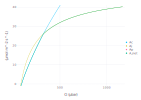

In [68]:
visualize(C3BB, :Ci, [:Ac, :Aj, :Ap, :A_net]; xstep = co2_xstep, ylim = (0,40), kind = :line)

#### A-Q

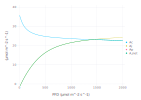

In [69]:
visualize(C3BB, :PFD, [:Ac, :Aj, :Ap, :A_net]; xstep = pfd_xstep, ylim = (0,40), kind = :line)

#### A-T

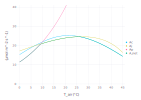

In [70]:
visualize(C3BB, :T_air, [:Ac, :Aj, :Ap, :A_net]; xstep = ta_xstep, ylim = (0,40), kind = :line)

### C4

#### A-Ci

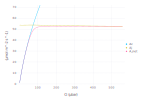

In [71]:
visualize(C4MED, :Ci, [:Ac, :Aj, :A_net]; xstep = co2_xstep, ylim = (0,70), kind = :line)

#### A-Q

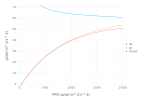

In [72]:
visualize(C4MED, :PFD, [:Ac, :Aj, :A_net]; xstep = pfd_xstep, ylim = (0,70), kind = :line)

#### A-T

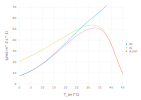

In [73]:
visualize(C4MED, :T_air, [:Ac, :Aj, :A_net]; xstep = ta_xstep, ylim = (0,70), kind = :line)

#### Transition smoothing factor ($\beta$)

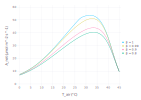

In [74]:
let S = C4MED, x = :T_air, y = :A_net, xstep = ta_xstep, ylim = (0,60), kind = :line
    p = visualize(S, x, y; xstep, ylim, kind, name = "β = 1", config = :0 => :β => 1)
    p = visualize!(p, S, x, y; xstep, kind, name = "β = 0.99", config = :0 => :β => 0.99)
    p = visualize!(p, S, x, y; xstep, kind, name = "β = 0.9", config = :0 => :β => 0.9)
    p = visualize!(p, S, x, y; xstep, kind, name = "β = 0.8", config = :0 => :β => 0.8)
end

In [75]:
manipulate(C4MED, :T_air, :A_net;
    parameters = :C4Rate => :β => 0.01:0.01:1,
    xstep = ta_xstep,
    ylim = (0,60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["C4Rate"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["β"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 100, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
50, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe261fec8b0, Task (runnable) @0x00007fe261fec8b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\

Explore how C3 and C4 leaves will respond over a wide range of temperatures under the atmospheric CO2 concentrations of **250 ppm, 400 ppm, and 1000 ppm**. Assume other environmental conditions are favorable with saturating light level (PFD = 2,000 $\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$).

In [76]:
@config co2_group

CO2,=,"[1000, 400, 250]"


Generate figures to compare C3 and C4 temperature response curves at different CO2 concentrations.

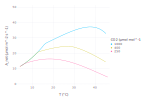

In [77]:
visualize(C3BB, :T, :A_net;
    xstep = ta_xstep,
    group = co2_group,
    ylim = (0,50),
    kind = :line,
)

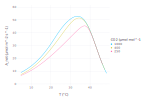

In [78]:
visualize(C4BB, :T, :A_net;
    xstep = ta_xstep,
    group = co2_group,
    ylim = (0,60),
    kind = :line,
)

Identify the **air temperature and CO2** conditions where photorespiration becomes substantial in the figures, and discuss why those conditions.

In [79]:
manipulate(C3BB, :Ci, [:Ac, :Aj, :Ap, :A_net];
    parameters = ta_xstep,
    xstep = co2_xstep,
    xlim = (0,500),
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["T_air (°C)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 46, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
23, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe25ed3f0f0, Task (runnable) @0x00007fe25ed3f0f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n      

In [80]:
manipulate(C4BB, :Ci, [:Ac, :Aj, :A_net];
    parameters = ta_xstep,
    xstep = co2_xstep,
    xlim = (0,500),
    ylim = (0,60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["T_air (°C)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 46, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
23, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe2626e1150, Task (runnable) @0x00007fe2626e1150), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n      

Do the same comparisons with water-stressed C3 and C4 leaves at -1.5 MPa of leaf water potential and compare their responses.

In [81]:
manipulate(C3BB, :T, :A_net;
    parameters = :StomataTuzet => :Ψv => -3:0.1:0,
    xstep = ta_xstep,
    group = co2_group,
    xlim = (0,50),
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["StomataTuzet"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Ψv (MPa)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 31, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
16, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe262580740, Task (runnable) @0x00007fe262580740), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n   

In [82]:
manipulate(C4BB, :T, :A_net;
    parameters = :StomataTuzet => :Ψv => -3:0.1:0,
    xstep = ta_xstep,
    group = co2_group,
    xlim = (0,50),
    ylim = (0,60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["StomataTuzet"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Ψv (MPa)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 31, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
16, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe262620d00, Task (runnable) @0x00007fe262620d00), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n   

Now replenish the leaves with ample water but reduce the light level to 200 $\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ of PFD and compare the responses.

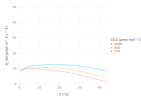

In [83]:
visualize(C3BB, :T, :A_net;
    config = :0 => (:Ψv => 0, :PFD => 200),
    xstep = ta_xstep,
    group = co2_group,
    ylim = (0,50),
    kind = :line,
)

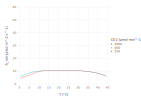

In [84]:
visualize(C4BB, :T, :A_net;
    config = :0 => (:Ψv => 0, :PFD => 200),
    xstep = ta_xstep,
    group = co2_group,
    ylim = (0,60),
    kind = :line,
)

In [85]:
manipulate(C3BB, :T, :A_net;
    parameters = (
        :StomataTuzet => :Ψv => -3:0.1:0,
        :Weather => :PFD => 0:100:2000,
    ),
    xstep = ta_xstep,
    group = co2_group,
    xlim = (0,50),
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["StomataTuzet"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Ψv (MPa)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 31, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
16, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe25f5aab30, Task (runnable) @0x00007fe25f5aab30), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n   

In [86]:
manipulate(C4BB, :T, :A_net;
    parameters = (
        :StomataTuzet => :Ψv => -3:0.1:0,
        :Weather => :PFD => 0:100:2000,
    ),
    xstep = ta_xstep,
    group = co2_group,
    xlim = (0,50),
    ylim = (0,60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["StomataTuzet"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Ψv (MPa)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 31, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
16, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe262b2a9c0, Task (runnable) @0x00007fe262b2a9c0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n   

Let's examine how leaf water and nitrogen status is implemented in the coupled model and study their behavior by experimenting with the parameter values associated their responses.

#### Nitrogen Stress

In [87]:
nitrogen_group = :NitrogenDependence => :N => 2:-0.5:0.5;
nitrogen_xstep = :NitrogenDependence => :N => 0.5:0.01:2.0;

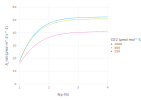

In [88]:
visualize(C4MED, :Np, :A_net;
    xstep = nitrogen_xstep,
    group = co2_group,
    ylim = (0,60),
    kind = :line,
)

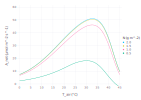

In [89]:
visualize(C4MED, :T_air, :A_net;
    xstep = ta_xstep,
    group = nitrogen_group,
    ylim = (0,60),
    kind = :line,
)

#### Water Stress

In [90]:
water_group = :StomataTuzet => :Ψv => 0:-0.5:-2;
water_xstep = :StomataTuzet => :Ψv => -2:0.02:0;

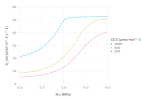

In [91]:
visualize(C4MED, :Ψv, :A_net;
    xstep = water_xstep,
    group = co2_group,
    ylim = (0,60),
    kind = :line,
)

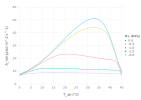

In [92]:
visualize(C4MED, :T_air, :A_net;
    xstep = ta_xstep,
    group = water_group,
    ylim = (0,60),
    kind = :line,
)

#### Nitrogen x Water Stress

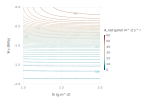

In [93]:
visualize(C4MED, :N, :Ψv, :A_net;
    config = :Weather => (),
    xstep = :NitrogenDependence => :N => 1:0.02:2,
    ystep = :StomataTuzet => :Ψv => -2:0.04:0,
    kind = :contour,
    aspect = 1,
    zlim = (0,60),
    zgap = 1,
    zlabgap = 10,
)

#### Interactive Plot

In [94]:
manipulate(C4MED, :T, :A_net;
    parameters = (
        :NitrogenDependence => :N => 0:0.05:3,
        :StomataTuzet => :Ψv => -3:0.05:0,
    ),
    xstep = ta_xstep,
    group = co2_group,
    xlim = (0,50),
    ylim = (0,60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["NitrogenDependence"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["N (g m^-2)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 61, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
31, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe262621fb0, Task (runnable) @0x00007fe262621fb0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                conte

## Model Expansion

The models we've used above can simulate the rate of photosynthesis at an individual leaf-level pretty accurately. However, the amount of CO2 assimilated to the single leaf doesn't automatically translate to the total amount of carbon assimilated at the canopy-level. There are a few approaches published for scaling photosynthesis from leaf to canopy. Let's take a look at "sunlit and shaded leaf model" which is one of the most widely used methods for scaling.

### Sun

We first need to know how much light would be available for *sunlit* leaves and *shaded* leaves. Sunlit leaves receive *directional light* and shaded leaves receive *diffusive light*. The ratio between two types of light is primarily determined by the location of light source, the sun, and it changes according to time and season. It is also influenced by the amount of cloud or dust in the air, which is represented by atmospheric transmissivity ($\tau$).

In [95]:
@system Sun begin
    weather ~ ::Weather(override)

    d: day  ~ preserve::int(parameter, u"d")
    h: hour ~ preserve::int(parameter, u"hr")

    ϕ: latitude   => 37.5u"°"  ~ preserve(parameter, u"°")
    λ: longitude  => 126.9u"°" ~ preserve(parameter, u"°")
    alt: altitude => 0         ~ preserve(parameter, u"m")

    Q: photosynthetic_active_radiation_conversion_factor => begin
        # 4.55 is a conversion factor from W to photons for solar radiation, Goudriaan and van Laar (1994)
        # some use 4.6 i.e., Amthor 1994, McCree 1981, Challa 1995.
        4.6
    end ~ preserve(u"μmol/J", parameter)

    solrad(weather.PFD, Q): solar_radiation => begin
        PFD / Q
    end ~ track(u"W/m^2")
    
    "atmospheric transmissivity, Goudriaan and van Laar (1994) p 30"
    τ: transmissivity => 0.5 ~ preserve(parameter)

    #####################
    # Solar Coordinates #
    #####################

    δ(declination_angle_spencer): declination_angle ~ track(u"°")

    "Spencer equation, Iqbal (1983) Pg 7 Eqn 1.3.1. Most accurate among all"
    declination_angle_spencer(d) => begin
        # gamma: day angle
        g = 2pi * (d - 1u"d") / 365u"d"
        0.006918 - 0.399912cos(g) + 0.070257sin(g) - 0.006758cos(2g) + 0.000907sin(2g) -0.002697cos(3g) + 0.00148sin(3g)
    end ~ track(u"rad")

    dph: degree_per_hour => 360u"°" / 24u"hr" ~ preserve(u"°/hr")

    "longitude correction for Light noon, Wohlfart et al, 2000; Campbell & Norman 1998"
    LC(λ, dph): longitude_correction => begin
        meridian = round(u"hr", λ / dph) * dph
        (meridian - λ) / dph
    end ~ track(u"hr")

    ET(d): equation_of_time => begin
        f = (279.575 + 0.9856u"d^-1" * d)*u"°"
        (-104.7sin(f) + 596.2sin(2f) + 4.3sin(3f) - 12.7sin(4f) -429.3cos(f) - 2.0cos(2f) + 19.3cos(3f)) / (60 * 60)
    end ~ track(u"hr")

    solar_noon(LC, ET) => 12u"hr" - LC - ET ~ track(u"hr")

    "θs: zenith angle"
    hour_angle_at(ϕ, δ; θs(u"°")) => begin
        c = (cos(θs) - sin(ϕ) * sin(δ)) / (cos(ϕ) * cos(δ))
        # c > 1: in the polar region during the winter, sun does not rise
        # c < -1: white nights during the summer in the polar region
        c = clamp(c, -1, 1)
        acosd(c)
    end ~ call(u"°")

    hour_angle_at_horizon(hour_angle_at) => hour_angle_at(90u"°") ~ track(u"°")

    "from Iqbal (1983) p 16"
    half_day_length(hour_angle_at_horizon, dph) => (hour_angle_at_horizon / dph) ~ track(u"hr")
    day_length(half_day_length)                 => 2half_day_length              ~ track(u"hr")

    sunrise(solar_noon, half_day_length) => (solar_noon - half_day_length) ~ track(u"hr")
    sunset(solar_noon, half_day_length)  => (solar_noon + half_day_length) ~ track(u"hr")

    hour_angle(h, solar_noon, dph) => ((h - solar_noon) * dph) ~ track(u"°")

    αs(h=hour_angle, δ, ϕ): elevation_angle => begin
        asind(cos(h) * cos(δ) * cos(ϕ) + sin(δ) * sin(ϕ))
    end ~ track(u"°")

    ts(αs): positive_elevation_angle      ~ track(u"°", min=0)
    θs(αs): zenith_angle => (90u"°" - αs) ~ track(u"°")

    """
    The solar azimuth angle is the angular distance between due South and the
    projection of the line of sight to the sun on the ground.
    View point from south, morning: +, afternoon: -
    See An introduction to solar radiation by Iqbal (1983) p 15-16
    Also see https://www.susdesign.com/sunangle/
    """
    ϕs(αs, δ, ϕ): azimuth_angle => begin
        acosd((sin(δ) - sin(αs) * sin(ϕ)) / (cos(αs) * cos(ϕ)))
    end ~ track(u"°")

    ###################
    # Solar Radiation #
    ###################

    "atmospheric pressure in kPa; Campbell and Norman (1998), p 41"
    p(altitude): atmospheric_pressure => begin
        101.3exp(-altitude / 8200u"m")
    end ~ track(u"kPa")

    m(p, ts): optical_air_mass_number => begin
        p / (101.3u"kPa" * sin(ts))
    end ~ track

    SC: solar_constant => 1370 ~ preserve(u"W/m^2", parameter)

    "Campbell and Norman's global solar radiation"
    insolation(ts, d, SC) => begin
        # solar constant, Iqbal (1983)
        #FIXME better to be 1361 or 1362 W/m-2?
        g = 2pi * (d - 10u"d") / 365u"d"
        SC * sin(ts) * (1 + 0.033cos(g))
    end ~ track(u"W/m^2")

    directional_solar_radiation(Fdir, solar_radiation) => begin
        Fdir * solar_radiation
    end ~ track(u"W/m^2")

    diffusive_solar_radiation(Fdif, solar_radiation) => begin
        Fdif * solar_radiation
    end ~ track(u"W/m^2")

    Fdir(τ, m): directional_coeff => begin
        # Campbell and Norman (1998), p 173
        τ^m
    end ~ track

    "Fraction of diffused light"
    Fdif(τ, m): diffusive_coeff => begin
        # Campbell and Norman (1998), p 173
        0.3(1 - τ^m)
    end ~ track

    directional_fraction(Fdif, Fdir) => (1 / (1 + Fdif/Fdir)) ~ track
    diffusive_fraction(Fdir, Fdif) => (1 / (1 + Fdir/Fdif)) ~ track

    PARfr(τ): photosynthetic_coeff => begin
        # Goudriaan and van Laar (1994)
        # clear sky (τ >= 0.7): 45% is PAR
        if τ >= 0.7
            0.45
        # cloudy sky (τ <= 0.3): 55% is PAR
        elseif τ <= 0.3
            0.55
        else
            0.625 - 0.25τ
        end
    end ~ track

    "total PAR (umol m-2 s-1) on horizontal surface (PFD)"
    PARtot(solar_radiation, PARfr, Q): photosynthetic_active_radiation_total => begin
        # conversion factor from W/m2 to PFD (umol m-2 s-1) for PAR waveband (median 550 nm of 400-700 nm) of solar radiation,
        # see Campbell and Norman (1994) p 149
        solar_radiation * PARfr * Q
    end ~ track(u"μmol/m^2/s") # Quanta

    PARdir(PARtot, directional_fraction): directional_photosynthetic_radiation => (directional_fraction * PARtot) ~ track(u"μmol/m^2/s") # Quanta
    PARdif(PARtot, diffusive_fraction): diffusive_photosynthetic_radiation     => (diffusive_fraction * PARtot)   ~ track(u"μmol/m^2/s") # Quanta
end

Sun

In [96]:
@system SunController(Controller) begin
    weather(context)         ~ ::Weather
    s(context, weather): sun ~ ::Sun
end

SunController

In [97]:
sun_config = @config(
    Sun => (;
        day = 200,
        hour = 12,
        latitude = 37.5,
        longitude = 126.9,
    ),
)

day,=,200 d
hour,=,12 hr
latitude,=,37.5°
longitude,=,126.9°


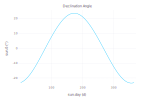

In [98]:
visualize(SunController, "sun.day", "sun.δ";
    title = "Declination Angle",
    config = sun_config,
    xstep = Sun => :day => 1:365,
    kind = :line,
)

In [99]:
manipulate(SunController, "sun.hour", "sun.αs";
    title = "Elevation Angle",
    parameters = Sun => (;
        latitude = -90:0.1:90,
        longitude = -180:0.1:180,
    ),
    config = sun_config,
    xstep = Sun => :hour => 0:23,
    ylim = (-90,90),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Sun"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["latitude (°)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 1801, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
1276, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe2632db540, Task (runnable) @0x00007fe2632db540), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n    

In [100]:
manipulate(SunController, "sun.hour", ["sun.Fdir", "sun.Fdif"];
    title = "Directional & Diffusive Coeff.",
    parameters = Sun => (;
        day = 1:365,
        :τ => 0:0.01:1
    ),
    config = sun_config,
    xstep = Sun => :hour => 0:23,
    ylim = (0,1),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Sun"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["day (d)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 365, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
200, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe2632948b0, Task (runnable) @0x00007fe2632948b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n           

### Radiation

Now we can calculate the amount of directional and diffusive lights available at a certain time and location. Then how much of these lights would be actually absorbed by which part of the canopy? They can greatly vary depending on the strucuture of canopy, leaf distribution, and leaf area index.

You may want to obtain an accurate geometric structure of the 3D canopy and apply ray casting to estimate the precise amount of light received by individual leaves. Of course, it's not an easy task. Instead, we can simplify the canopy structure by assuming there are only two types of leaf: sunlit leaf and shaded leaf. The sunlit leaf receives only directional light and the sunilt leaf receives only diffusive light. This model is thus called "sunlit-shaded leaf" model.

There are lots of variables, but the most important ones include leaf angle and leaf area index (LAI). They are major factors that control the ratio between direct and diffusive lights in the canopy. Once the amount of each light is determined, leaf-level gas-exchange model we once developed would be geared up two times, one for the sunlit leaf, and the other for the shaded leaf. The total rate of photosynthesis for the canopy would be then calculated by multiplying the portion of LAI for each leaf, which are also determined by this new module of system.

In [101]:
@enum LeafAngle begin
    spherical = 1
    horizontal = 2
    vertical = 3
    diaheliotropic = 4
    empirical = 5
    ellipsoidal = 6
end

In [102]:
@enum WaveBand begin
    photosynthetically_active_radiation = 1
    near_infrared = 2
    longwave = 3
end

In [103]:
@system Radiation begin
    sun                  ~ ::Sun(override)
    LAI: leaf_area_index ~ track(override)

    leaf_angle => ellipsoidal ~ preserve::LeafAngle(parameter)

    "ratio of horizontal to vertical axis of an ellipsoid"
    LAF: leaf_angle_factor => begin
        #1
        # leaf angle factor for corn leaves, Campbell and Norman (1998)
        #1.37
        # leaf angle factor for garlic canopy, from Rizzalli et al. (2002),  X factor in Campbell and Norman (1998)
        0.7
    end ~ preserve(parameter)

    wave_band => photosynthetically_active_radiation ~ preserve::WaveBand(parameter)

    "scattering coefficient (reflectance + transmittance)"
    s: scattering => 0.15 ~ preserve(parameter)

    "clumping index"
    clumping => 1.0 ~ preserve(parameter)

    # Forward from Sun

    current_zenith_angle(sun.zenith_angle) ~ track(u"°")
    elevation_angle(sun.αs)                ~ track(u"°")

    I0_dr(sun.PARdir): directional_photosynthetic_radiation ~ track(u"μmol/m^2/s" #= Quanta =#)
    I0_df(sun.PARdif): diffusive_photosynthetic_radiation   ~ track(u"μmol/m^2/s" #= Quanta =#)

    leaf_angle_coeff(a=leaf_angle, leaf_angle_factor; zenith_angle(u"°")) => begin
        elevation_angle = 90u"°" - zenith_angle
        α = elevation_angle
        t = zenith_angle
        # leaf angle distribution parameter
        x = leaf_angle_factor
        if a == spherical
            # When Lt accounts for total path length, division by sin(elev) isn't necessary
            1 / (2sin(α))
        elseif a == horizontal
            1
        elseif a == vertical
            1 / (tan(α) * π/2)
        elseif a == empirical
            0.667
        elseif a == diaheliotropic
            1 / sin(α)
        elseif a == ellipsoidal
            sqrt(x^2 + tan(t)^2) / (x + 1.774 * (x+1.182)^-0.733)
        else
            1
        end
    end ~ call

    "extinction coefficient assuming spherical leaf dist"
    Kb_at(leaf_angle_coeff, clumping; zenith_angle(u"°")): projection_ratio_at => begin
        leaf_angle_coeff(zenith_angle) * clumping
    end ~ call

    Kb(Kb_at, current_zenith_angle): projection_ratio => begin
        Kb_at(current_zenith_angle)
    end ~ track

    "diffused light ratio to ambient, integrated over all incident angles from 0 to 90"
    Kd_F(leaf_angle_coeff, LAI; a): diffused_fraction_for_Kd => begin
        c = leaf_angle_coeff(a)
        x = exp(-c * LAI)
        2x * sin(a) * cos(a)
    end ~ integrate(from=0, to=π/2)

    "K for diffuse light, the same literature as above"
    Kd(F=Kd_F, LAI, clumping): diffusion_ratio => begin
        K = -log(F) / LAI
        K * clumping
    end ~ track

    ###############################
    # de Pury and Farquhar (1997) #
    ###############################

    "Kb prime in de Pury and Farquhar(1997)"
    Kb1(Kb, s): projection_ratio_prime => (Kb * sqrt(1 - s)) ~ track

    "Kd prime in de Pury and Farquhar(1997)"
    Kd1(Kd, s): diffusion_ratio_prime => (Kd * sqrt(1 - s)) ~ track

    ################
    # Reflectivity #
    ################

    reflectivity(rho_h, Kb, Kd) => begin
        rho_h * (2Kb / (Kb + Kd))
    end ~ track

    # canopy reflection coefficients for beam horizontal leaves, beam uniform leaves, and diffuse radiations

    """
    canopy reflectance of beam irradiance on horizontal leaves, de Pury and Farquhar (1997)
    also see Campbell and Norman (1998) p 255 for further info on potential problems
    """
    rho_h(s): canopy_reflectivity_horizontal_leaf => begin
        (1 - sqrt(1 - s)) / (1 + sqrt(1 - s))
    end ~ track

    "canopy reflectance of beam irradiance for uniform leaf angle distribution, de Pury and Farquhar (1997)"
    rho_cb_at(rho_h, Kb_at; zenith_angle): canopy_reflectivity_uniform_leaf_at => begin
        Kb = Kb_at(zenith_angle)
        1 - exp(-2rho_h * Kb / (1 + Kb))
    end ~ call

    rho_cb(rho_cb_at, current_zenith_angle): canopy_reflectivity_uniform_leaf => begin
        rho_cb_at(current_zenith_angle)
    end ~ track

    rho_cd_F(rho_cb_at; a): diffused_fraction_for_rho_cd => begin
        x = rho_cb_at(a)
        2x * sin(a) * cos(a)
    end ~ integrate(from=0, to=π/2)

    "canopy reflectance of diffuse irradiance, de Pury and Farquhar (1997) Table A2"
    rho_cd(I0_df, rho_cd_F): canopy_reflectivity_diffusion => begin
        iszero(I0_df) ? 0 : rho_cd_F
    end ~ track

    "soil reflectivity for PAR band"
    rho_soil: soil_reflectivity => 0.10 ~ preserve(parameter)

    #######################
    # I_l?: dePury (1997) #
    #######################

    "dePury (1997) eqn A3"
    I_lb(I0_dr, rho_cb, Kb1; L): irradiance_lb => begin
        I0_dr * (1 - rho_cb) * Kb1 * exp(-Kb1 * L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "dePury (1997) eqn A5"
    I_ld(I0_df, rho_cb, Kd1; L): irradiance_ld => begin
        I0_df * (1 - rho_cb) * Kd1 * exp(-Kd1 * L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "dePury (1997) eqn A5"
    I_l(; L): irradiance_l => (I_lb(L) + I_ld(L)) ~ call(u"μmol/m^2/s" #= Quanta =#)

    "dePury (1997) eqn A5"
    I_lbSun(I0_dr, s, Kb, I_lSh; L): irradiance_l_sunlit => begin
        I_lb_sunlit = I0_dr * (1 - s) * Kb
        #TODO: check name I_lbSun vs. I_l_sunlit?
        I_l_sunlit = I_lb_sunlit + I_lSh(L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "dePury (1997) eqn A5"
    I_lSh(I_ld, I_lbs; L): irradiance_l_shaded => begin
        I_ld(L) + I_lbs(L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "dePury (1997) eqn A5"
    I_lbs(I0_dr, rho_cb, s, Kb1, Kb; L): irradiance_lbs => begin
        I0_dr * ((1 - rho_cb) * Kb1 * exp(-Kb1 * L) - (1 - s) * Kb * exp(-Kb * L))
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    """
    total irradiance at the top of the canopy,
    passed over from either observed PAR or TSolar or TIrradiance
    """
    I0_tot(I0_dr, I0_df): irradiance_I0_tot => (I0_dr + I0_df) ~ track(u"μmol/m^2/s" #= Quanta =#)

    ########
    # I_c? #
    ########

    # I_tot, I_sun, I_shade: absorbed irradiance integrated over LAI per ground area

    "Total irradiance absorbed by the canopy, de Pury and Farquhar (1997)"
    I_c(rho_cb, I0_dr, I0_df, Kb1, Kd1, LAI): canopy_irradiance => begin
        #I_c = I_cSun + I_cSh
        I(I0, K) = (1 - rho_cb) * I0 * (1 - exp(-K * LAI))
        I_tot = I(I0_dr, Kb1) + I(I0_df, Kd1)
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "The irradiance absorbed by the sunlit fraction, de Pury and Farquhar (1997)"
    I_cSun(s, rho_cb, rho_cd, I0_dr, I0_df, Kb, Kb1, Kd1, LAI): canopy_sunlit_irradiance => begin
        I_c_sunlit = begin
            I0_dr * (1 - s) * (1 - exp(-Kb * LAI)) +
            I0_df * (1 - rho_cd) * (1 - exp(-(Kd1 + Kb) * LAI)) * Kd1 / (Kd1 + Kb) +
            I0_dr * ((1 - rho_cb) * (1 - exp(-(Kb1 + Kb) * LAI)) * Kb1 / (Kb1 + Kb) - (1 - s) * (1 - exp(-2Kb * LAI)) / 2)
        end
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "The irradiance absorbed by the shaded fraction, de Pury and Farquhar (1997)"
    I_cSh(I_c, I_cSun): canopy_shaded_irradiance => (I_c - I_cSun) ~ track(u"μmol/m^2/s" #= Quanta =#)

    ######
    # Q? #
    ######

    "total irradiance (dir + dif) at depth L, simple empirical approach"
    Q_tot(I0_tot, s, Kb, Kd; L): irradiance_Q_tot => begin
        I0_tot * exp(-sqrt(1 - s) * ((Kb + Kd) / 2) * L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "total beam radiation at depth L"
    Q_bt(I0_dr, s, Kb; L): irradiance_Q_bt => begin
        I0_dr * exp(-sqrt(1 - s) * Kb * L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "net diffuse flux at depth of L within canopy"
    Q_d(I0_dr, s, Kd; L): irradiance_Q_d => begin
        I0_df * exp(-sqrt(1 - s) * Kd * L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    """
    weighted average absorbed diffuse flux over depth of L within canopy
    accounting for exponential decay, Campbell p261
    """
    Q_dm(LAI, I0_df, s, Kd): irradiance_Q_dm => begin
        # Integral Qd / Integral L
        Q = I0_df * (1 - exp(-sqrt(1 - s) * Kd * LAI)) / (sqrt(1 - s) * Kd * LAI)
        isnan(Q) ? zero(Q) : Q
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "unintercepted beam (direct beam) flux at depth of L within canopy"
    Q_b(I0_dr, Kb; L): irradiance_Q_b => begin
        I0_dr * exp(-Kb * L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "mean flux density on sunlit leaves"
    Q_sun(I0_dr, Kb, Q_sh): irradiance_Q_sunlit => begin
        I0_dr * Kb + Q_sh
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "flux density on sunlit leaves at depth L"
    Q_sun_at(I0_dr, Kb; L): irradiance_Q_sunlit_at => begin
        I0_dr * Kb + Q_sh_at(L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "mean flux density on shaded leaves over LAI"
    Q_sh(Q_dm, Q_scm): irradiance_Q_shaded => begin
        # It does not include soil reflection
        Q_dm + Q_scm
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "diffuse flux density on shaded leaves at depth L"
    Q_sh_at(Q_d, Q_sc; L): irradiance_Q_shaded_at => begin
        # It does not include soil reflection
        Q_d(L) + Q_sc(L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "weighted average of Soil reflectance over canopy accounting for exponential decay"
    Q_soilm(LAI, rho_soil, s, Kd, Q_soil): irradiance_Q_soilm => begin
        # Integral Qd / Integral L
        Q = Q_soil * rho_soil * (1 - exp(-sqrt(1 - s) * Kd * LAI)) / (sqrt(1 - s) * Kd * LAI)
        isnan(Q) ? zero(Q) : Q
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "weighted average scattered radiation within canopy"
    Q_scm(LAI, I0_dr, s, Kb): irradiance_Q_scm => begin
        # total beam including scattered absorbed by canopy
        #FIXME should the last part be multiplied by LAI like others?
        #TODO simplify by using existing variables (i.e. Q_bt, Q_b)
        total_beam = I0_dr * (1 - exp(-sqrt(1 - s) * Kb * LAI)) / (sqrt(1 - s) * Kb)
        # non scattered beam absorbed by canopy
        nonscattered_beam = I0_dr * (1 - exp(-Kb * LAI)) / Kb
        Q = (total_beam - nonscattered_beam) / LAI
        # Campbell and Norman (1998) p 261, Average between top (where scattering is 0) and bottom.
        #(self.Q_bt(LAI) - Q_b(LAI)) / 2
        isnan(Q) ? zero(Q) : Q
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "scattered radiation at depth L in the canopy"
    Q_sc(Q_bt, Q_b; L): irradiance_Q_sc => begin
        # total beam - nonscattered beam at depth L
        Q_bt(L) - Q_b(L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "total PFD at the soil surface under the canopy"
    Q_soil(LAI, Q_tot): irradiance_Q_soil => Q_tot(LAI) ~ track(u"μmol/m^2/s" #= Quanta =#)

    ###################
    # Leaf Area Index #
    ###################

    sunrisen(elevation_angle, minimum_elevation_angle=5u"°") => begin
        elevation_angle > minimum_elevation_angle
    end ~ flag

    "sunlit LAI assuming closed canopy; thus not accurate for row or isolated canopy"
    LAI_sunlit(sunrisen, Kb, LAI): sunlit_leaf_area_index => begin
        sunrisen ? (1 - exp(-Kb * LAI)) / Kb : 0
    end ~ track

    "shaded LAI assuming closed canopy"
    LAI_shaded(LAI, LAI_sunlit): shaded_leaf_area_index => begin
        LAI - LAI_sunlit
    end ~ track

    "sunlit fraction of current layer"
    sunlit_fraction(sunrisen, Kb; L) => begin
        sunrisen ? exp(-Kb * L) : 0
    end ~ call

    shaded_fraction(sunlit_fraction; L) => begin
        1 - sunlit_fraction(L)
    end ~ call
end

Radiation

In [104]:
@system RadiationController(Radiation, Controller) begin
    weather(context)      ~ ::Weather
    sun(context, weather) ~ ::Sun
    LAI: leaf_area_index  ~ preserve(parameter)
end

RadiationController

In [105]:
manipulate(RadiationController, "sun.hour", [:Q_sun, :Q_sh];
    parameters = (
        Sun => (;
            day = 1:365,
        ),
        :0 => (;
            LAI = 0:20,
        ),
        Radiation => (;
            leaf_angle = LeafAngle,
        ),
    ),
    xstep = Sun => :hour => 0:23,
    ylim = (0,1000),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Sun"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["day (d)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 365, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
183, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe277c28010, Task (runnable) @0x00007fe277c28010), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n           

In [106]:
manipulate(RadiationController, "sun.hour", [:LAI_sunlit, :LAI_shaded];
    config = :0 => :LAI => 10,
    parameters = (
        Sun => (;
            day = 1:365,
        ),
        Radiation => (;
            leaf_angle = LeafAngle,
        ),
    ),
    xstep = Sun => :hour => 0:23,
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Sun"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["day (d)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 365, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
183, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe25ec352c0, Task (runnable) @0x00007fe25ec352c0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n           

### Integration

Now it's time to make a system for the canopy which is composed of sunlit and shaded leaves and integrated with other modules we created earlier.

`Sun` system calculates the amount of directional and diffisuive lights, which are adjusted by `Radiation` system relying on the canopy structure. Then two separate gas-exchange systems inside `Canopy` can now run to get net photosynthesis rate of the canopy (`A_net`; $\mathrm{\mu mol\; m^{-2}\; s^{-1}}$), which can be converted to net assimilation rate (`net_assimilation`; $\mathrm{g\; d^{-1}}$) by taking account of molar mass of carbohydrates.

In [107]:
@system C3BBC(GasExchange, StomataBallBerry, C3) begin
    PPFD: photosynthetic_photon_flux_density ~ track(u"μmol/m^2/s" #= Quanta =#, override)
    LAI: leaf_area_index                     ~ track(override)

    A_net_total(A_net, LAI): net_photosynthesis_total       => A_net * LAI   ~ track(u"μmol/m^2/s" #= CO2 =#)
    A_gross_total(A_gross, LAI): gross_photosynthesis_total => A_gross * LAI ~ track(u"μmol/m^2/s" #= CO2 =#)
    E_total(E, LAI): transpiration_total                    => E * LAI       ~ track(u"mmol/m^2/s" #= H2O =#)
end

C3BBC

In [108]:
@system Canopy(Controller) begin
    weather(context)             ~ ::Weather
    sun(context, weather)        ~ ::Sun
    radiation(context, sun, LAI) ~ ::Radiation

    LAI: leaf_area_index       ~ preserve(parameter)
    PD: planting_density => 55 ~ preserve(parameter, u"m^-2")

    H2O_weight  => 18.01528 ~ preserve(u"g/mol")
    CO2_weight  => 44.0098  ~ preserve(u"g/mol")
    CH2O_weight => 30.031   ~ preserve(u"g/mol")

    sunlit_gasexchange(context, weather, PPFD=Q_sun, LAI=LAI_sunlit) ~ ::C3BBC
    shaded_gasexchange(context, weather, PPFD=Q_sh,  LAI=LAI_shaded) ~ ::C3BBC

    leaf_width => begin
        #5.0 # for maize
        1.5 # for garlic
    end ~ preserve(u"cm", parameter)

    LAI_sunlit(radiation.sunlit_leaf_area_index): sunlit_leaf_area_index ~ track
    LAI_shaded(radiation.shaded_leaf_area_index): shaded_leaf_area_index ~ track

    Q_sun(radiation.irradiance_Q_sunlit): sunlit_irradiance ~ track(u"μmol/m^2/s" #= Quanta =#)
    Q_sh(radiation.irradiance_Q_shaded): shaded_irradiance  ~ track(u"μmol/m^2/s" #= Quanta =#)

    A_gross(a=sunlit_gasexchange.A_gross_total, b=shaded_gasexchange.A_gross_total): gross_CO2_umol_per_m2_s => begin
        a + b
    end ~ track(u"μmol/m^2/s" #= CO2 =#)

    A_net(a=sunlit_gasexchange.A_net_total, b=shaded_gasexchange.A_net_total): net_CO2_umol_per_m2_s => begin
        a + b
    end ~ track(u"μmol/m^2/s" #= CO2 =#)

    gross_assimilation(A_gross, PD, w=CH2O_weight) => begin
        A_gross / PD * w
    end ~ track(u"g/d")

    net_assimilation(A_net, PD, w=CH2O_weight) => begin
        A_net / PD * w
    end ~ track(u"g/d")

    conductance(gs_sun=sunlit_gasexchange.gs, LAI_sunlit, gs_sh=shaded_gasexchange.gs, LAI_shaded, LAI) => begin
        c = ((gs_sun * LAI_sunlit) + (gs_sh * LAI_shaded)) / LAI
        iszero(LAI) ? zero(c) : c
    end ~ track(u"mol/m^2/s/bar")
end

Canopy

In [109]:
config = @config(
    Sun => (;
        day = 200,
        hour = 12,
    ),
    StomataBallBerry => (;
        g0 = 0.096,
        g1 = 6.824,
    ),
    Canopy => (;
        :LAI => 5,
    ),
    Radiation => (;
        :leaf_angle_factor => 3,
        :leaf_angle => horizontal,
    ),
)

day,=,200 d
hour,=,12 hr
g0,=,0.096 mol bar^-1 m^-2 s^-1
g1,=,6.824
LAI,=,5
leaf_angle_factor,=,3
leaf_angle,=,horizontal


In [110]:
manipulate(Canopy, "weather.CO2", [:A_net, "sunlit_gasexchange.A_net", "shaded_gasexchange.A_net"];
    config,
    parameters = (
        Canopy => :LAI => 0:0.1:20,
        Radiation => :leaf_angle => LeafAngle,
    ),
    xstep = Weather => :CO2 => 10:10:1000,
    ylim = (0,50),
    kind = :line,
    ylab = "A_net",
    names = ["Total", "Sunlit", "Shaded"],
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Canopy"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["LAI"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe262661150, Task (runnable) @0x00007fe262661150), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            )

In [111]:
manipulate(Canopy, "weather.PFD", [:A_net, "sunlit_gasexchange.A_net", "shaded_gasexchange.A_net"];
    config,
    parameters = (
        Canopy => :LAI => 0:0.1:20,
        Radiation => :leaf_angle => LeafAngle,
    ),
    xstep = Weather => :PFD => 0:10:2000,
    ylim = (0,50),
    kind = :line,
    ylab = "A_net",
    names = ["Total", "Sunlit", "Shaded"],
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Canopy"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["LAI"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe261864fe0, Task (runnable) @0x00007fe261864fe0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            )

In [112]:
manipulate(Canopy, "weather.T_air", [:A_net, "sunlit_gasexchange.A_net", "shaded_gasexchange.A_net"];
    config,
    parameters = (
        Canopy => :LAI => 0:0.1:20,
        Radiation => :leaf_angle => LeafAngle,
    ),
    xstep = Weather => :T_air => -10:50,
    ylim = (0,50),
    kind = :line,
    ylab = "A_net",
    names = ["Total", "Sunlit", "Shaded"],
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Canopy"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["LAI"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fe260fef820, Task (runnable) @0x00007fe260fef820), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            )